In [3]:
%pip install -U sentence-transformers
import statistics
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from confusion_matrix import show_matrix, show_stats, show_percentage_matrix
from sklearn.model_selection import KFold
from embeddings_manipulation import *
from stats import *
import numpy as np

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'embeddings_manipulation'

In [ ]:
def run(model_name, train_keys, df=None, dfs=None, k=10, knn=3, printing=True, save_classified_bool=False):
    df = pd.read_csv("posts/filtered.csv")
    # dataframes used (rn are only used for extracting appropriate indices and then applying those to the initial df)
    dfs = {
        "ukr_uk": df[df["post_origin"] == "ukr"][df["post_lang"] == "uk"],
        "ukr_ru": df[df["post_origin"] == "ukr"][df["post_lang"] == "ru"],
        "rus_ru": df[df["post_origin"] == "rus"][df["post_lang"] == "ru"],
    }
    if printing:
        print(model_name)

    # k-fold iterators for dataframes
    df_iters = {key: KFold(n_splits=k, shuffle=True, random_state=1).split(df) for key, df in dfs.items()}

    # print("reading / splitting ok")
    iteration = 0

    embeddings = read_save_embeddings(df, model_name)

    original_indices = {k: dataframe.index.to_numpy() for k, dataframe in dfs.items()}
    stats = {k: [] for k in dfs.keys()}

    for i in range(k):
        train_indices_dict = {}
        test_indices_dict = {}
        for key in dfs.keys():
            train_split, test_split = next(df_iters[key])
            train_indices_dict[key] = original_indices[key][train_split]
            test_indices_dict[key] = original_indices[key][test_split]
        train_indices_concatenated = np.concatenate(
            [indices for k, indices in train_indices_dict.items() if k in train_keys], axis=None)
        train_df = df.iloc[train_indices_concatenated]  # FIXME - possibly use actual train_dfs not initial df
        train_embeddings = embeddings[train_indices_concatenated]

        test_dfs = {key: df.loc[test_indices_dict[key]] for key, df in dfs.items()}
        for key, test_df in test_dfs.items():
            # print(key)

            test_labels = test_df["label"].to_list()
            test_embeddings = embeddings[test_indices_dict[key]]

            sentence_combinations = generate_sentence_combinations(train_embeddings, test_embeddings)

            classified = classify(sentence_combinations, train_df, knn=knn)
            if save_classified_bool:
                save_classified(test_labels, classified, train_keys, key, iteration, test_indices_dict)

            tp, tn, fp, fn = calc_stats(classified, test_labels)
            w = test_labels.count("w")
            n = test_labels.count("n")
            recall = round(tp / w, 2) if w != 0 else 1
            specificity = round(tn / n, 2) if n != 0 else 1
            fpr = 1 - specificity
            prec = round(tp / (tp + fp), 2)
            stats[key].append(
                dict(w=w, n=n, tp=tp, tn=tn, fp=fp, fn=fn, corrw=recall, spec=specificity, prec=prec, fpr=fpr))

        iteration += 1

    if printing:
        print_average_stats(stats, dfs)
    # return stats

In [ ]:
# model_name = 'distiluse-base-multilingual-cased-v1' # no UK
model_name = 'distiluse-base-multilingual-cased-v2'
# model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
# model_name = 'paraphrase-multilingual-mpnet-base-v2'

- dfs: dataframes that you'll see output for (comment/uncomment the corresponding lines)

- train_keys: keys of the dataframes that will be included for training

- - if the dataset is present in dfs but its key is excluded from train_keys, you will see the result for this dataset, but it will NOT be used for training

- knn: used in classify(); the number of nearest neighbors


***
#'distiluse-base-multilingual-cased-v2'

In [ ]:
model_name = 'distiluse-base-multilingual-cased-v2'

In [ ]:
# indicates dataframes used for training. in contrast with dfs dictionary that keeps the dataframes that are used for testing
train_keys = [
    "ukr_uk",
    # "ukr_ru",
    # "rus_ru",
]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


distiluse-base-multilingual-cased-v2

ukr_uk: [{'w': 18, 'n': 9, 'tp': 17, 'tn': 5, 'fp': 4, 'fn': 1, 'corrw': 0.94, 'spec': 0.56, 'prec': 0.81, 'fpr': 0.43999999999999995}, {'w': 18, 'n': 9, 'tp': 18, 'tn': 7, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.9, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 3, 'fp': 5, 'fn': 3, 'corrw': 0.84, 'spec': 0.38, 'prec': 0.76, 'fpr': 0.62}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 3, 'fp': 5, 'fn': 2, 'corrw': 0.89, 'spec': 0.38, 'prec': 0.76, 'fpr': 0.62}, {'w': 14, 'n': 12, 'tp': 10, 'tn': 8, 'fp': 4, 'fn': 4, 'corrw': 0.71, 'spec': 0.67, 'prec': 0.71, 'fpr': 0.32999999999999996}, {'w': 14, 'n': 12, 'tp': 13, 'tn': 6, 'fp': 6, 'fn': 1, 'corrw': 0.93, 'spec': 0.5, 'prec': 0.68, 'fpr': 0.5}, {'w': 16, 'n': 10, 'tp': 16, 'tn': 3, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.3, 'prec': 0.7, 'fpr': 0.7}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 2, 'fp': 11, 'fn': 0, 'corrw': 1.0, 'spec': 0.15, 'prec': 0.54, 'fpr': 0.85}, {'w': 10, 'n': 1

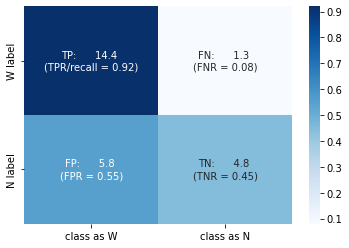


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 8, 'fp': 5, 'fn': 1, 'corrw': 0.93, 'spec': 0.62, 'prec': 0.72, 'fpr': 0.38}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 11, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.58, 'prec': 0.5, 'fpr': 0.42000000000000004}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 12, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.67, 'prec': 0.6, 'fpr': 0.32999999999999996}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 7, 'fp': 8, 'fn': 1, 'corrw': 0.91, 'spec': 0.47, 'prec': 0.56, 'fpr': 0.53}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 13, 'fp': 7, 'fn': 1, 'corrw': 0.83, 'spec': 0.65, 'prec': 0.42, 'fpr': 0.35}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 8, 'fp': 7, 'fn': 2, 'corrw': 0.82, 'spec': 0.53, 'prec': 0.56, 'fpr': 0.47}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 10, 'fp': 8, 'fn': 1, 'corrw': 0.88, 'spec': 0.56, 'prec': 0.47, 'fpr': 0.43999999999999995}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 5, 'fp': 11, 'fn': 0, 'corrw': 1.0, 'spec': 0.31, 'prec': 0.48, 'fpr': 0.69}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 9, 'fp': 9, 'fn':

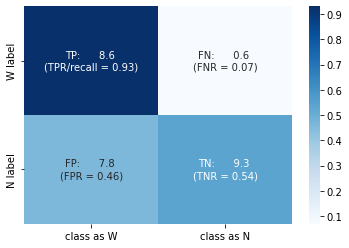


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 11, 'fp': 14, 'fn': 0, 'corrw': 1.0, 'spec': 0.44, 'prec': 0.18, 'fpr': 0.56}, {'w': 4, 'n': 24, 'tp': 4, 'tn': 9, 'fp': 15, 'fn': 0, 'corrw': 1.0, 'spec': 0.38, 'prec': 0.21, 'fpr': 0.62}, {'w': 3, 'n': 25, 'tp': 3, 'tn': 8, 'fp': 17, 'fn': 0, 'corrw': 1.0, 'spec': 0.32, 'prec': 0.15, 'fpr': 0.6799999999999999}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 1, 'fp': 21, 'fn': 0, 'corrw': 1.0, 'spec': 0.05, 'prec': 0.22, 'fpr': 0.95}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 12, 'fp': 14, 'fn': 0, 'corrw': 1.0, 'spec': 0.46, 'prec': 0.12, 'fpr': 0.54}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 9, 'fp': 13, 'fn': 1, 'corrw': 0.83, 'spec': 0.41, 'prec': 0.28, 'fpr': 0.5900000000000001}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 5, 'fp': 17, 'fn': 0, 'corrw': 1.0, 'spec': 0.23, 'prec': 0.23, 'fpr': 0.77}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 8, 'fp': 17, 'fn': 0, 'corrw': 1.0, 'spec': 0.32, 'prec': 0.11, 'fpr': 0.6799999999999999}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 11, 'fp': 12, 'fn': 0, '

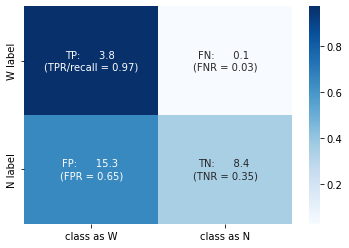

In [ ]:
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 6, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.67, 'prec': 0.84, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 15, 'tn': 5, 'fp': 4, 'fn': 3, 'corrw': 0.83, 'spec': 0.56, 'prec': 0.79, 'fpr': 0.43999999999999995}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 5, 'fp': 3, 'fn': 3, 'corrw': 0.84, 'spec': 0.62, 'prec': 0.84, 'fpr': 0.38}, {'w': 18, 'n': 8, 'tp': 13, 'tn': 3, 'fp': 5, 'fn': 5, 'corrw': 0.72, 'spec': 0.38, 'prec': 0.72, 'fpr': 0.62}, {'w': 14, 'n': 12, 'tp': 11, 'tn': 9, 'fp': 3, 'fn': 3, 'corrw': 0.79, 'spec': 0.75, 'prec': 0.79, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 10, 'tn': 8, 'fp': 4, 'fn': 4, 'corrw': 0.71, 'spec': 0.67, 'prec': 0.71, 'fpr': 0.32999999999999996}, {'w': 16, 'n': 10, 'tp': 12, 'tn': 7, 'fp': 3, 'fn': 4, 'corrw': 0.75, 'spec': 0.7, 'prec': 0.8, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 6, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.46, 'prec': 0.65, 'fpr': 0.54}, {'w': 10, 'n': 16, 'tp': 9, 'tn':

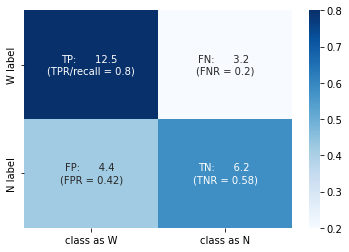


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 11, 'fp': 2, 'fn': 1, 'corrw': 0.93, 'spec': 0.85, 'prec': 0.87, 'fpr': 0.15000000000000002}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 16, 'fp': 3, 'fn': 1, 'corrw': 0.88, 'spec': 0.84, 'prec': 0.7, 'fpr': 0.16000000000000003}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 10, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.53, 'fpr': 0.43999999999999995}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 12, 'fp': 3, 'fn': 1, 'corrw': 0.91, 'spec': 0.8, 'prec': 0.77, 'fpr': 0.19999999999999996}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 13, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.65, 'prec': 0.46, 'fpr': 0.35}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 8, 'fp': 7, 'fn': 1, 'corrw': 0.91, 'spec': 0.53, 'prec': 0.59, 'fpr': 0.47}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 15, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.83, 'prec': 0.73, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 11, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.69, 'prec': 0.67, 'fpr': 0.31000000000000005}, {'w

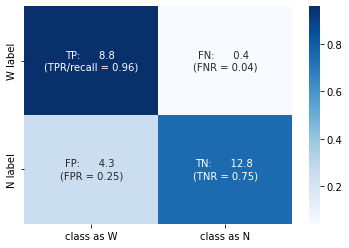


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 17, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.68, 'prec': 0.27, 'fpr': 0.31999999999999995}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 16, 'fp': 8, 'fn': 2, 'corrw': 0.5, 'spec': 0.67, 'prec': 0.2, 'fpr': 0.32999999999999996}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 15, 'fp': 10, 'fn': 1, 'corrw': 0.67, 'spec': 0.6, 'prec': 0.17, 'fpr': 0.4}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 14, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.64, 'prec': 0.43, 'fpr': 0.36}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 19, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.73, 'prec': 0.22, 'fpr': 0.27}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 17, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.55, 'fpr': 0.22999999999999998}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 12, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.55, 'prec': 0.33, 'fpr': 0.44999999999999996}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 18, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.72, 'prec': 0.22, 'fpr': 0.28}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 15, 'fp':

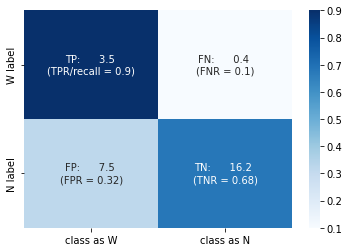

In [ ]:
train_keys = [
    # "ukr_uk",
    "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 9, 'tn': 7, 'fp': 2, 'fn': 9, 'corrw': 0.5, 'spec': 0.78, 'prec': 0.82, 'fpr': 0.21999999999999997}, {'w': 18, 'n': 9, 'tp': 11, 'tn': 7, 'fp': 2, 'fn': 7, 'corrw': 0.61, 'spec': 0.78, 'prec': 0.85, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 10, 'tn': 6, 'fp': 2, 'fn': 9, 'corrw': 0.53, 'spec': 0.75, 'prec': 0.83, 'fpr': 0.25}, {'w': 18, 'n': 8, 'tp': 11, 'tn': 4, 'fp': 4, 'fn': 7, 'corrw': 0.61, 'spec': 0.5, 'prec': 0.73, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 8, 'tn': 10, 'fp': 2, 'fn': 6, 'corrw': 0.57, 'spec': 0.83, 'prec': 0.8, 'fpr': 0.17000000000000004}, {'w': 14, 'n': 12, 'tp': 5, 'tn': 11, 'fp': 1, 'fn': 9, 'corrw': 0.36, 'spec': 0.92, 'prec': 0.83, 'fpr': 0.07999999999999996}, {'w': 16, 'n': 10, 'tp': 11, 'tn': 7, 'fp': 3, 'fn': 5, 'corrw': 0.69, 'spec': 0.7, 'prec': 0.79, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 8, 'tn': 9, 'fp': 4, 'fn': 5, 'corrw': 0.62, 'spec': 0.69, 'prec': 0.67, 'fpr': 0.31000000000000005}, {'w': 1

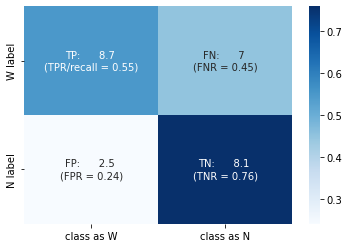


ukr_ru: [{'w': 14, 'n': 13, 'tp': 10, 'tn': 12, 'fp': 1, 'fn': 4, 'corrw': 0.71, 'spec': 0.92, 'prec': 0.91, 'fpr': 0.07999999999999996}, {'w': 8, 'n': 19, 'tp': 6, 'tn': 18, 'fp': 1, 'fn': 2, 'corrw': 0.75, 'spec': 0.95, 'prec': 0.86, 'fpr': 0.050000000000000044}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 15, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.83, 'prec': 0.75, 'fpr': 0.17000000000000004}, {'w': 11, 'n': 15, 'tp': 7, 'tn': 13, 'fp': 2, 'fn': 4, 'corrw': 0.64, 'spec': 0.87, 'prec': 0.78, 'fpr': 0.13}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 17, 'fp': 3, 'fn': 1, 'corrw': 0.83, 'spec': 0.85, 'prec': 0.62, 'fpr': 0.15000000000000002}, {'w': 11, 'n': 15, 'tp': 8, 'tn': 14, 'fp': 1, 'fn': 3, 'corrw': 0.73, 'spec': 0.93, 'prec': 0.89, 'fpr': 0.06999999999999995}, {'w': 8, 'n': 18, 'tp': 5, 'tn': 15, 'fp': 3, 'fn': 3, 'corrw': 0.62, 'spec': 0.83, 'prec': 0.62, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 14, 'fp': 2, 'fn': 2, 'corrw': 0.8, 'spec': 0.88, 'prec': 0.8, 'fpr': 0.12}, {

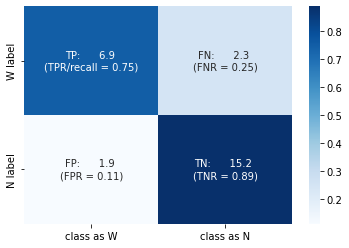


rus_ru: [{'w': 3, 'n': 25, 'tp': 2, 'tn': 23, 'fp': 2, 'fn': 1, 'corrw': 0.67, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 23, 'fp': 1, 'fn': 2, 'corrw': 0.5, 'spec': 0.96, 'prec': 0.67, 'fpr': 0.040000000000000036}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 23, 'fp': 2, 'fn': 2, 'corrw': 0.33, 'spec': 0.92, 'prec': 0.33, 'fpr': 0.07999999999999996}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 22, 'fp': 0, 'fn': 0, 'corrw': 1.0, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 26, 'fp': 0, 'fn': 0, 'corrw': 1.0, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 19, 'fp': 3, 'fn': 2, 'corrw': 0.67, 'spec': 0.86, 'prec': 0.57, 'fpr': 0.14}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 21, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.95, 'prec': 0.83, 'fpr': 0.050000000000000044}, {'w': 2, 'n': 25, 'tp': 1, 'tn': 24, 'fp': 1, 'fn': 1, 'corrw': 0.5, 'spec': 0.96, 'prec': 0.5, 'fpr': 0.040000000000000036}, {'w': 4, 'n': 23, 'tp': 1, 't

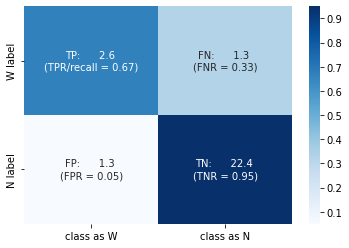

In [ ]:
train_keys = [
    # "ukr_uk",
    # "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 6, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.67, 'prec': 0.84, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 18, 'tn': 7, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.9, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 18, 'tn': 4, 'fp': 4, 'fn': 1, 'corrw': 0.95, 'spec': 0.5, 'prec': 0.82, 'fpr': 0.5}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 2, 'fp': 6, 'fn': 2, 'corrw': 0.89, 'spec': 0.25, 'prec': 0.73, 'fpr': 0.75}, {'w': 14, 'n': 12, 'tp': 10, 'tn': 9, 'fp': 3, 'fn': 4, 'corrw': 0.71, 'spec': 0.75, 'prec': 0.77, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 8, 'fp': 4, 'fn': 2, 'corrw': 0.86, 'spec': 0.67, 'prec': 0.75, 'fpr': 0.32999999999999996}, {'w': 16, 'n': 10, 'tp': 14, 'tn': 7, 'fp': 3, 'fn': 2, 'corrw': 0.88, 'spec': 0.7, 'prec': 0.82, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 3, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.23, 'prec': 0.57, 'fpr': 0.77}, {'w': 10, 'n': 16, 'tp': 9, 'tn': 6

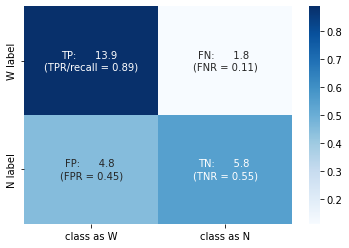


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 10, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.82, 'fpr': 0.22999999999999998}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 14, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.74, 'prec': 0.62, 'fpr': 0.26}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 11, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.61, 'prec': 0.56, 'fpr': 0.39}, {'w': 11, 'n': 15, 'tp': 11, 'tn': 10, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.67, 'prec': 0.69, 'fpr': 0.32999999999999996}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 17, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.85, 'prec': 0.67, 'fpr': 0.15000000000000002}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 8, 'fp': 7, 'fn': 2, 'corrw': 0.82, 'spec': 0.53, 'prec': 0.56, 'fpr': 0.47}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 15, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.83, 'prec': 0.73, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 10, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.62, 'prec': 0.62, 'fpr': 0.38}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 14

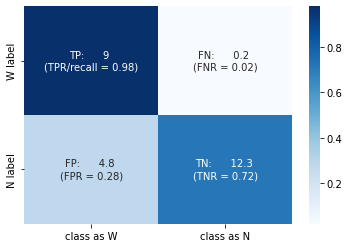


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 13, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.52, 'prec': 0.2, 'fpr': 0.48}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 15, 'fp': 9, 'fn': 2, 'corrw': 0.5, 'spec': 0.62, 'prec': 0.18, 'fpr': 0.38}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 13, 'fp': 12, 'fn': 1, 'corrw': 0.67, 'spec': 0.52, 'prec': 0.14, 'fpr': 0.48}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 10, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.45, 'prec': 0.33, 'fpr': 0.55}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 19, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.73, 'prec': 0.22, 'fpr': 0.27}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 15, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.68, 'prec': 0.46, 'fpr': 0.31999999999999995}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 10, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.45, 'prec': 0.29, 'fpr': 0.55}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 18, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.72, 'prec': 0.22, 'fpr': 0.28}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 16, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.7, '

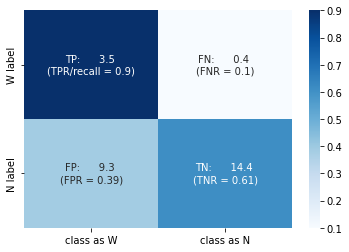

In [ ]:
train_keys = [
    "ukr_uk",
    "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 12, 'tn': 6, 'fp': 3, 'fn': 6, 'corrw': 0.67, 'spec': 0.67, 'prec': 0.8, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 13, 'tn': 7, 'fp': 2, 'fn': 5, 'corrw': 0.72, 'spec': 0.78, 'prec': 0.87, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 17, 'tn': 4, 'fp': 4, 'fn': 2, 'corrw': 0.89, 'spec': 0.5, 'prec': 0.81, 'fpr': 0.5}, {'w': 18, 'n': 8, 'tp': 13, 'tn': 4, 'fp': 4, 'fn': 5, 'corrw': 0.72, 'spec': 0.5, 'prec': 0.76, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 8, 'tn': 9, 'fp': 3, 'fn': 6, 'corrw': 0.57, 'spec': 0.75, 'prec': 0.73, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 8, 'tn': 10, 'fp': 2, 'fn': 6, 'corrw': 0.57, 'spec': 0.83, 'prec': 0.8, 'fpr': 0.17000000000000004}, {'w': 16, 'n': 10, 'tp': 10, 'tn': 8, 'fp': 2, 'fn': 6, 'corrw': 0.62, 'spec': 0.8, 'prec': 0.83, 'fpr': 0.19999999999999996}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 7, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.54, 'prec': 0.68, 'fpr': 0.45999999999999996}, {'w': 10, 'n': 16, 'tp':

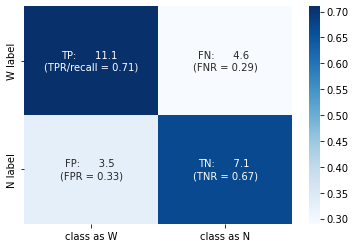


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 12, 'fp': 1, 'fn': 1, 'corrw': 0.93, 'spec': 0.92, 'prec': 0.93, 'fpr': 0.07999999999999996}, {'w': 8, 'n': 19, 'tp': 6, 'tn': 18, 'fp': 1, 'fn': 2, 'corrw': 0.75, 'spec': 0.95, 'prec': 0.86, 'fpr': 0.050000000000000044}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 14, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.69, 'fpr': 0.21999999999999997}, {'w': 11, 'n': 15, 'tp': 8, 'tn': 13, 'fp': 2, 'fn': 3, 'corrw': 0.73, 'spec': 0.87, 'prec': 0.8, 'fpr': 0.13}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 16, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.6, 'fpr': 0.19999999999999996}, {'w': 11, 'n': 15, 'tp': 8, 'tn': 11, 'fp': 4, 'fn': 3, 'corrw': 0.73, 'spec': 0.73, 'prec': 0.67, 'fpr': 0.27}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 15, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.83, 'prec': 0.73, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 12, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.75, 'prec': 0.71, 'fpr': 0.25}, {'w': 8, 'n': 18, '

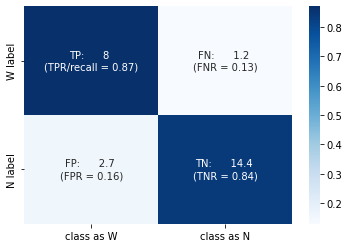


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 22, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.88, 'prec': 0.5, 'fpr': 0.12}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 22, 'fp': 2, 'fn': 2, 'corrw': 0.5, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 21, 'fp': 4, 'fn': 2, 'corrw': 0.33, 'spec': 0.84, 'prec': 0.2, 'fpr': 0.16000000000000003}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 20, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.91, 'prec': 0.75, 'fpr': 0.08999999999999997}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 26, 'fp': 0, 'fn': 0, 'corrw': 1.0, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 19, 'fp': 3, 'fn': 2, 'corrw': 0.67, 'spec': 0.86, 'prec': 0.57, 'fpr': 0.14}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 18, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.82, 'prec': 0.56, 'fpr': 0.18000000000000005}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 22, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.88, 'prec': 0.4, 'fpr': 0.12}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 16, 'fp': 7, '

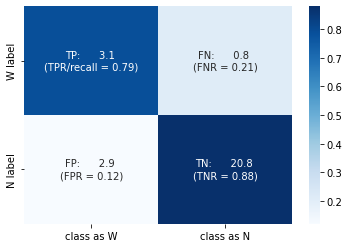

In [ ]:
train_keys = [
    # "ukr_uk",
    "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 6, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.67, 'prec': 0.84, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 15, 'tn': 7, 'fp': 2, 'fn': 3, 'corrw': 0.83, 'spec': 0.78, 'prec': 0.88, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 5, 'fp': 3, 'fn': 3, 'corrw': 0.84, 'spec': 0.62, 'prec': 0.84, 'fpr': 0.38}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 4, 'fp': 4, 'fn': 2, 'corrw': 0.89, 'spec': 0.5, 'prec': 0.8, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 9, 'tn': 10, 'fp': 2, 'fn': 5, 'corrw': 0.64, 'spec': 0.83, 'prec': 0.82, 'fpr': 0.17000000000000004}, {'w': 14, 'n': 12, 'tp': 11, 'tn': 6, 'fp': 6, 'fn': 3, 'corrw': 0.79, 'spec': 0.5, 'prec': 0.65, 'fpr': 0.5}, {'w': 16, 'n': 10, 'tp': 14, 'tn': 5, 'fp': 5, 'fn': 2, 'corrw': 0.88, 'spec': 0.5, 'prec': 0.74, 'fpr': 0.5}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 5, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.38, 'prec': 0.62, 'fpr': 0.62}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 10, 'fp': 6, 'fn':

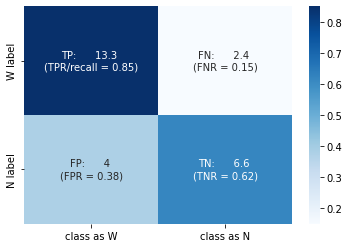


ukr_ru: [{'w': 14, 'n': 13, 'tp': 11, 'tn': 10, 'fp': 3, 'fn': 3, 'corrw': 0.79, 'spec': 0.77, 'prec': 0.79, 'fpr': 0.22999999999999998}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 15, 'fp': 4, 'fn': 1, 'corrw': 0.88, 'spec': 0.79, 'prec': 0.64, 'fpr': 0.20999999999999996}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 15, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.83, 'prec': 0.75, 'fpr': 0.17000000000000004}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 10, 'fp': 5, 'fn': 1, 'corrw': 0.91, 'spec': 0.67, 'prec': 0.67, 'fpr': 0.32999999999999996}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 14, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.7, 'prec': 0.5, 'fpr': 0.30000000000000004}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 10, 'fp': 5, 'fn': 2, 'corrw': 0.82, 'spec': 0.67, 'prec': 0.64, 'fpr': 0.32999999999999996}, {'w': 8, 'n': 18, 'tp': 6, 'tn': 12, 'fp': 6, 'fn': 2, 'corrw': 0.75, 'spec': 0.67, 'prec': 0.5, 'fpr': 0.32999999999999996}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 11, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.69, 'prec': 0.67, 'f

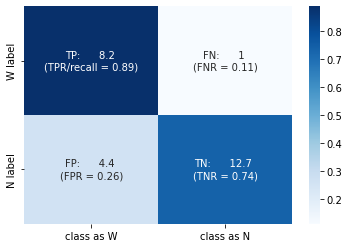


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 16, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.64, 'prec': 0.25, 'fpr': 0.36}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 20, 'fp': 4, 'fn': 2, 'corrw': 0.5, 'spec': 0.83, 'prec': 0.33, 'fpr': 0.17000000000000004}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 24, 'fp': 1, 'fn': 2, 'corrw': 0.33, 'spec': 0.96, 'prec': 0.5, 'fpr': 0.040000000000000036}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 19, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.86, 'prec': 0.67, 'fpr': 0.14}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 24, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 17, 'fp': 5, 'fn': 2, 'corrw': 0.67, 'spec': 0.77, 'prec': 0.44, 'fpr': 0.22999999999999998}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 14, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.64, 'prec': 0.38, 'fpr': 0.36}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 22, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.88, 'prec': 0.4, 'fpr': 0.12}, {'w': 4, 'n': 23, 'tp': 3, 'tn': 18, 'fp':

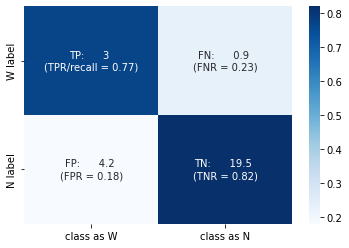

In [ ]:
train_keys = [
    "ukr_uk",
    # "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 15, 'tn': 6, 'fp': 3, 'fn': 3, 'corrw': 0.83, 'spec': 0.67, 'prec': 0.83, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 16, 'tn': 7, 'fp': 2, 'fn': 2, 'corrw': 0.89, 'spec': 0.78, 'prec': 0.89, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 17, 'tn': 4, 'fp': 4, 'fn': 2, 'corrw': 0.89, 'spec': 0.5, 'prec': 0.81, 'fpr': 0.5}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 3, 'fp': 5, 'fn': 2, 'corrw': 0.89, 'spec': 0.38, 'prec': 0.76, 'fpr': 0.62}, {'w': 14, 'n': 12, 'tp': 9, 'tn': 10, 'fp': 2, 'fn': 5, 'corrw': 0.64, 'spec': 0.83, 'prec': 0.82, 'fpr': 0.17000000000000004}, {'w': 14, 'n': 12, 'tp': 11, 'tn': 8, 'fp': 4, 'fn': 3, 'corrw': 0.79, 'spec': 0.67, 'prec': 0.73, 'fpr': 0.32999999999999996}, {'w': 16, 'n': 10, 'tp': 14, 'tn': 7, 'fp': 3, 'fn': 2, 'corrw': 0.88, 'spec': 0.7, 'prec': 0.82, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 5, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.38, 'prec': 0.62, 'fpr': 0.62}, {'w': 10, 'n': 16, 

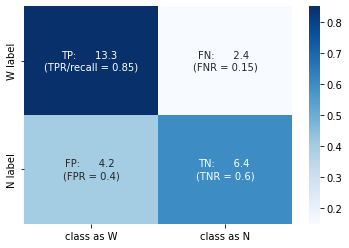


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 12, 'fp': 1, 'fn': 1, 'corrw': 0.93, 'spec': 0.92, 'prec': 0.93, 'fpr': 0.07999999999999996}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 17, 'fp': 2, 'fn': 1, 'corrw': 0.88, 'spec': 0.89, 'prec': 0.78, 'fpr': 0.10999999999999999}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 14, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.69, 'fpr': 0.21999999999999997}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 11, 'fp': 4, 'fn': 1, 'corrw': 0.91, 'spec': 0.73, 'prec': 0.71, 'fpr': 0.27}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 16, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.6, 'fpr': 0.19999999999999996}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 9, 'fp': 6, 'fn': 2, 'corrw': 0.82, 'spec': 0.6, 'prec': 0.6, 'fpr': 0.4}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 15, 'fp': 3, 'fn': 1, 'corrw': 0.88, 'spec': 0.83, 'prec': 0.7, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 11, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.69, 'prec': 0.67, 'fpr': 0.31000000000000005}, {'w': 8

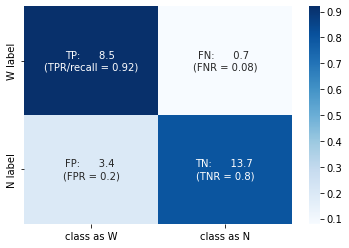


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 18, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.72, 'prec': 0.3, 'fpr': 0.28}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 19, 'fp': 5, 'fn': 2, 'corrw': 0.5, 'spec': 0.79, 'prec': 0.29, 'fpr': 0.20999999999999996}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 22, 'fp': 3, 'fn': 2, 'corrw': 0.33, 'spec': 0.88, 'prec': 0.25, 'fpr': 0.12}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 20, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.91, 'prec': 0.75, 'fpr': 0.08999999999999997}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 25, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.96, 'prec': 0.67, 'fpr': 0.040000000000000036}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 16, 'fp': 6, 'fn': 2, 'corrw': 0.67, 'spec': 0.73, 'prec': 0.4, 'fpr': 0.27}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 17, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.5, 'fpr': 0.22999999999999998}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 20, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.29, 'fpr': 0.19999999999999996}, {'w': 4, 'n': 23, 'tp': 4, '

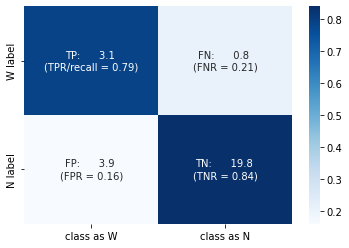

In [ ]:
train_keys = [
    "ukr_uk",
    "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

***
#'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'

In [ ]:
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 7, 'fp': 2, 'fn': 2, 'corrw': 0.89, 'spec': 0.78, 'prec': 0.89, 'fpr': 0.21999999999999997}, {'w': 18, 'n': 9, 'tp': 17, 'tn': 6, 'fp': 3, 'fn': 1, 'corrw': 0.94, 'spec': 0.67, 'prec': 0.85, 'fpr': 0.32999999999999996}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 4, 'fp': 4, 'fn': 3, 'corrw': 0.84, 'spec': 0.5, 'prec': 0.8, 'fpr': 0.5}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 5, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.62, 'prec': 0.84, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 9, 'fp': 3, 'fn': 2, 'corrw': 0.86, 'spec': 0.75, 'prec': 0.8, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 14, 'tn': 8, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.67, 'prec': 0.78, 'fpr': 0.32999999999999996}, {'w': 16, 'n': 10, 'tp': 13, 'tn': 5, 'fp': 5, 'fn': 3, 'corrw': 0.81, 'spec': 0.5, 'prec': 0.72, 'fpr': 0.5}, {'w': 13, 'n': 13, 'tp': 12, 'tn': 3, 'fp': 10, 'fn': 1, 'corrw': 0.92, 'spec': 0.23, 'prec': 0.55, 'fpr': 0.77}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 8, 'fp': 8, 'fn'

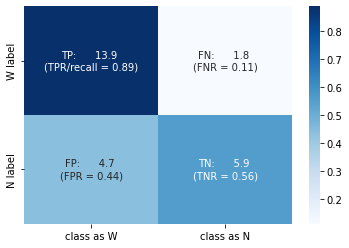


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 7, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.54, 'prec': 0.7, 'fpr': 0.45999999999999996}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 12, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.63, 'prec': 0.53, 'fpr': 0.37}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 10, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.53, 'fpr': 0.43999999999999995}, {'w': 11, 'n': 15, 'tp': 11, 'tn': 9, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.6, 'prec': 0.65, 'fpr': 0.4}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 13, 'fp': 7, 'fn': 1, 'corrw': 0.83, 'spec': 0.65, 'prec': 0.42, 'fpr': 0.35}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 6, 'fp': 9, 'fn': 1, 'corrw': 0.91, 'spec': 0.4, 'prec': 0.53, 'fpr': 0.6}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 10, 'fp': 8, 'fn': 1, 'corrw': 0.88, 'spec': 0.56, 'prec': 0.47, 'fpr': 0.43999999999999995}, {'w': 10, 'n': 16, 'tp': 9, 'tn': 6, 'fp': 10, 'fn': 1, 'corrw': 0.9, 'spec': 0.38, 'prec': 0.47, 'fpr': 0.62}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 14, 'fp': 4, 'fn': 0, 

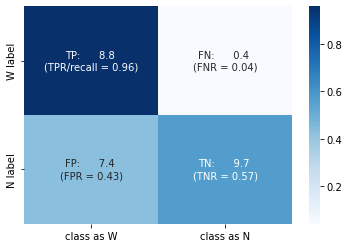


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 8, 'fp': 17, 'fn': 0, 'corrw': 1.0, 'spec': 0.32, 'prec': 0.15, 'fpr': 0.6799999999999999}, {'w': 4, 'n': 24, 'tp': 4, 'tn': 8, 'fp': 16, 'fn': 0, 'corrw': 1.0, 'spec': 0.33, 'prec': 0.2, 'fpr': 0.6699999999999999}, {'w': 3, 'n': 25, 'tp': 3, 'tn': 9, 'fp': 16, 'fn': 0, 'corrw': 1.0, 'spec': 0.36, 'prec': 0.16, 'fpr': 0.64}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 5, 'fp': 17, 'fn': 1, 'corrw': 0.83, 'spec': 0.23, 'prec': 0.23, 'fpr': 0.77}, {'w': 2, 'n': 26, 'tp': 1, 'tn': 10, 'fp': 16, 'fn': 1, 'corrw': 0.5, 'spec': 0.38, 'prec': 0.06, 'fpr': 0.62}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 12, 'fp': 10, 'fn': 1, 'corrw': 0.83, 'spec': 0.55, 'prec': 0.33, 'fpr': 0.44999999999999996}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 5, 'fp': 17, 'fn': 0, 'corrw': 1.0, 'spec': 0.23, 'prec': 0.23, 'fpr': 0.77}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 11, 'fp': 14, 'fn': 0, 'corrw': 1.0, 'spec': 0.44, 'prec': 0.12, 'fpr': 0.56}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 11, 'fp': 12, 'fn': 0,

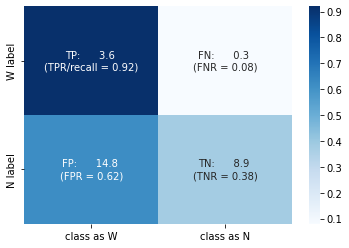

In [ ]:
train_keys = [
    "ukr_uk",
    # "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 17, 'tn': 6, 'fp': 3, 'fn': 1, 'corrw': 0.94, 'spec': 0.67, 'prec': 0.85, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 17, 'tn': 7, 'fp': 2, 'fn': 1, 'corrw': 0.94, 'spec': 0.78, 'prec': 0.89, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 4, 'fp': 4, 'fn': 3, 'corrw': 0.84, 'spec': 0.5, 'prec': 0.8, 'fpr': 0.5}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 4, 'fp': 4, 'fn': 2, 'corrw': 0.89, 'spec': 0.5, 'prec': 0.8, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 13, 'tn': 8, 'fp': 4, 'fn': 1, 'corrw': 0.93, 'spec': 0.67, 'prec': 0.76, 'fpr': 0.32999999999999996}, {'w': 14, 'n': 12, 'tp': 13, 'tn': 10, 'fp': 2, 'fn': 1, 'corrw': 0.93, 'spec': 0.83, 'prec': 0.87, 'fpr': 0.17000000000000004}, {'w': 16, 'n': 10, 'tp': 13, 'tn': 7, 'fp': 3, 'fn': 3, 'corrw': 0.81, 'spec': 0.7, 'prec': 0.81, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 6, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.46, 'prec': 0.65, 'fpr': 0.54}, {'w': 10, 'n': 16, 'tp

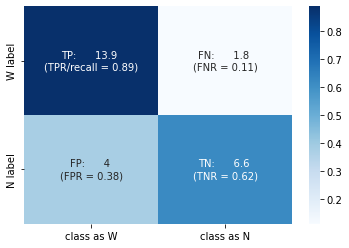


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 11, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.85, 'prec': 0.88, 'fpr': 0.15000000000000002}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 14, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.74, 'prec': 0.62, 'fpr': 0.26}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 9, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.5, 'prec': 0.5, 'fpr': 0.5}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 10, 'fp': 5, 'fn': 1, 'corrw': 0.91, 'spec': 0.67, 'prec': 0.67, 'fpr': 0.32999999999999996}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 13, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.65, 'prec': 0.46, 'fpr': 0.35}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 8, 'fp': 7, 'fn': 2, 'corrw': 0.82, 'spec': 0.53, 'prec': 0.56, 'fpr': 0.47}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 13, 'fp': 5, 'fn': 1, 'corrw': 0.88, 'spec': 0.72, 'prec': 0.58, 'fpr': 0.28}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 9, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.59, 'fpr': 0.43999999999999995}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 14, 'fp': 4, 'fn': 0

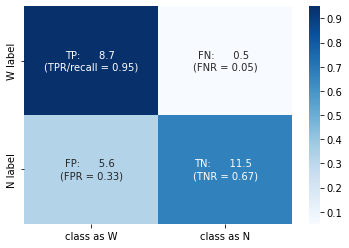


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 15, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.6, 'prec': 0.23, 'fpr': 0.4}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 17, 'fp': 7, 'fn': 1, 'corrw': 0.75, 'spec': 0.71, 'prec': 0.3, 'fpr': 0.29000000000000004}, {'w': 3, 'n': 25, 'tp': 3, 'tn': 14, 'fp': 11, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.21, 'fpr': 0.43999999999999995}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 12, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.55, 'prec': 0.38, 'fpr': 0.44999999999999996}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 15, 'fp': 11, 'fn': 0, 'corrw': 1.0, 'spec': 0.58, 'prec': 0.15, 'fpr': 0.42000000000000004}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 18, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.82, 'prec': 0.6, 'fpr': 0.18000000000000005}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 11, 'fp': 11, 'fn': 0, 'corrw': 1.0, 'spec': 0.5, 'prec': 0.31, 'fpr': 0.5}, {'w': 2, 'n': 25, 'tp': 1, 'tn': 14, 'fp': 11, 'fn': 1, 'corrw': 0.5, 'spec': 0.56, 'prec': 0.08, 'fpr': 0.43999999999999995}, {'w': 4, 'n

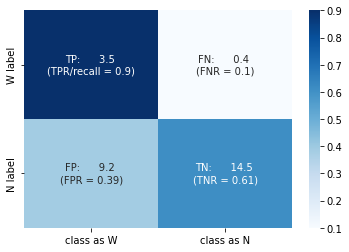

In [ ]:
train_keys = [
    # "ukr_uk",
    "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 11, 'tn': 9, 'fp': 0, 'fn': 7, 'corrw': 0.61, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 18, 'n': 9, 'tp': 11, 'tn': 7, 'fp': 2, 'fn': 7, 'corrw': 0.61, 'spec': 0.78, 'prec': 0.85, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 9, 'tn': 7, 'fp': 1, 'fn': 10, 'corrw': 0.47, 'spec': 0.88, 'prec': 0.9, 'fpr': 0.12}, {'w': 18, 'n': 8, 'tp': 12, 'tn': 7, 'fp': 1, 'fn': 6, 'corrw': 0.67, 'spec': 0.88, 'prec': 0.92, 'fpr': 0.12}, {'w': 14, 'n': 12, 'tp': 7, 'tn': 11, 'fp': 1, 'fn': 7, 'corrw': 0.5, 'spec': 0.92, 'prec': 0.88, 'fpr': 0.07999999999999996}, {'w': 14, 'n': 12, 'tp': 7, 'tn': 11, 'fp': 1, 'fn': 7, 'corrw': 0.5, 'spec': 0.92, 'prec': 0.88, 'fpr': 0.07999999999999996}, {'w': 16, 'n': 10, 'tp': 9, 'tn': 10, 'fp': 0, 'fn': 7, 'corrw': 0.56, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 13, 'n': 13, 'tp': 9, 'tn': 10, 'fp': 3, 'fn': 4, 'corrw': 0.69, 'spec': 0.77, 'prec': 0.75, 'fpr': 0.22999999999999998}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 14, '

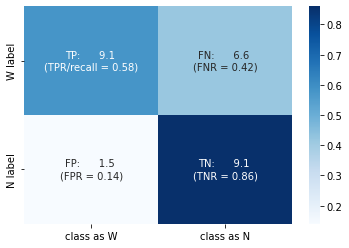


ukr_ru: [{'w': 14, 'n': 13, 'tp': 12, 'tn': 12, 'fp': 1, 'fn': 2, 'corrw': 0.86, 'spec': 0.92, 'prec': 0.92, 'fpr': 0.07999999999999996}, {'w': 8, 'n': 19, 'tp': 4, 'tn': 18, 'fp': 1, 'fn': 4, 'corrw': 0.5, 'spec': 0.95, 'prec': 0.8, 'fpr': 0.050000000000000044}, {'w': 9, 'n': 18, 'tp': 7, 'tn': 15, 'fp': 3, 'fn': 2, 'corrw': 0.78, 'spec': 0.83, 'prec': 0.7, 'fpr': 0.17000000000000004}, {'w': 11, 'n': 15, 'tp': 6, 'tn': 14, 'fp': 1, 'fn': 5, 'corrw': 0.55, 'spec': 0.93, 'prec': 0.86, 'fpr': 0.06999999999999995}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 16, 'fp': 4, 'fn': 1, 'corrw': 0.83, 'spec': 0.8, 'prec': 0.56, 'fpr': 0.19999999999999996}, {'w': 11, 'n': 15, 'tp': 8, 'tn': 14, 'fp': 1, 'fn': 3, 'corrw': 0.73, 'spec': 0.93, 'prec': 0.89, 'fpr': 0.06999999999999995}, {'w': 8, 'n': 18, 'tp': 3, 'tn': 15, 'fp': 3, 'fn': 5, 'corrw': 0.38, 'spec': 0.83, 'prec': 0.5, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 15, 'fp': 1, 'fn': 2, 'corrw': 0.8, 'spec': 0.94, 'prec': 0.89, 'fp

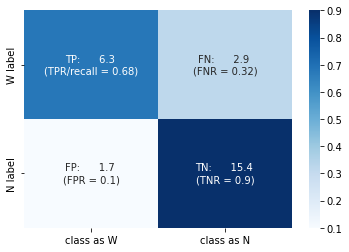


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 24, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.96, 'prec': 0.75, 'fpr': 0.040000000000000036}, {'w': 4, 'n': 24, 'tp': 1, 'tn': 24, 'fp': 0, 'fn': 3, 'corrw': 0.25, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 22, 'fp': 3, 'fn': 2, 'corrw': 0.33, 'spec': 0.88, 'prec': 0.25, 'fpr': 0.12}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 22, 'fp': 0, 'fn': 2, 'corrw': 0.67, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 25, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.96, 'prec': 0.67, 'fpr': 0.040000000000000036}, {'w': 6, 'n': 22, 'tp': 3, 'tn': 20, 'fp': 2, 'fn': 3, 'corrw': 0.5, 'spec': 0.91, 'prec': 0.6, 'fpr': 0.08999999999999997}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 18, 'fp': 4, 'fn': 1, 'corrw': 0.8, 'spec': 0.82, 'prec': 0.5, 'fpr': 0.18000000000000005}, {'w': 2, 'n': 25, 'tp': 1, 'tn': 22, 'fp': 3, 'fn': 1, 'corrw': 0.5, 'spec': 0.88, 'prec': 0.25, 'fpr': 0.12}, {'w': 4, 'n': 23, 'tp': 2, 'tn': 19, 'fp': 4,

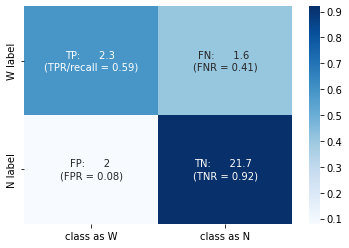

In [ ]:
train_keys = [
    # "ukr_uk",
    # "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 5, 'fp': 4, 'fn': 2, 'corrw': 0.89, 'spec': 0.56, 'prec': 0.8, 'fpr': 0.43999999999999995}, {'w': 18, 'n': 9, 'tp': 17, 'tn': 7, 'fp': 2, 'fn': 1, 'corrw': 0.94, 'spec': 0.78, 'prec': 0.89, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 17, 'tn': 5, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.62, 'prec': 0.85, 'fpr': 0.38}, {'w': 18, 'n': 8, 'tp': 15, 'tn': 5, 'fp': 3, 'fn': 3, 'corrw': 0.83, 'spec': 0.62, 'prec': 0.83, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 12, 'fp': 0, 'fn': 2, 'corrw': 0.86, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 14, 'n': 12, 'tp': 14, 'tn': 9, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.75, 'prec': 0.82, 'fpr': 0.25}, {'w': 16, 'n': 10, 'tp': 13, 'tn': 9, 'fp': 1, 'fn': 3, 'corrw': 0.81, 'spec': 0.9, 'prec': 0.93, 'fpr': 0.09999999999999998}, {'w': 13, 'n': 13, 'tp': 12, 'tn': 5, 'fp': 8, 'fn': 1, 'corrw': 0.92, 'spec': 0.38, 'prec': 0.6, 'fpr': 0.62}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 8, 'fp': 8, 'fn'

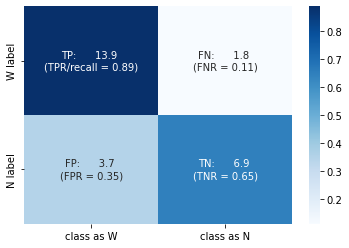


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 10, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.82, 'fpr': 0.22999999999999998}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 14, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.74, 'prec': 0.62, 'fpr': 0.26}, {'w': 9, 'n': 18, 'tp': 8, 'tn': 12, 'fp': 6, 'fn': 1, 'corrw': 0.89, 'spec': 0.67, 'prec': 0.57, 'fpr': 0.32999999999999996}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 11, 'fp': 4, 'fn': 1, 'corrw': 0.91, 'spec': 0.73, 'prec': 0.71, 'fpr': 0.27}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 13, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.65, 'prec': 0.46, 'fpr': 0.35}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 8, 'fp': 7, 'fn': 1, 'corrw': 0.91, 'spec': 0.53, 'prec': 0.59, 'fpr': 0.47}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 13, 'fp': 5, 'fn': 1, 'corrw': 0.88, 'spec': 0.72, 'prec': 0.58, 'fpr': 0.28}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 10, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.62, 'prec': 0.62, 'fpr': 0.38}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 15, 'fp': 3, 'fn': 0, 'corrw

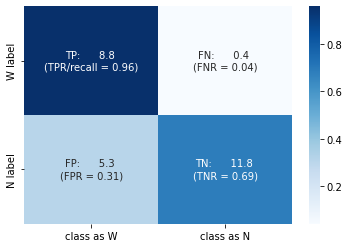


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 12, 'fp': 13, 'fn': 0, 'corrw': 1.0, 'spec': 0.48, 'prec': 0.19, 'fpr': 0.52}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 15, 'fp': 9, 'fn': 1, 'corrw': 0.75, 'spec': 0.62, 'prec': 0.25, 'fpr': 0.38}, {'w': 3, 'n': 25, 'tp': 3, 'tn': 12, 'fp': 13, 'fn': 0, 'corrw': 1.0, 'spec': 0.48, 'prec': 0.19, 'fpr': 0.52}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 13, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.59, 'prec': 0.4, 'fpr': 0.41000000000000003}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 15, 'fp': 11, 'fn': 0, 'corrw': 1.0, 'spec': 0.58, 'prec': 0.15, 'fpr': 0.42000000000000004}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 16, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.73, 'prec': 0.5, 'fpr': 0.27}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 9, 'fp': 13, 'fn': 0, 'corrw': 1.0, 'spec': 0.41, 'prec': 0.28, 'fpr': 0.5900000000000001}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 16, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.64, 'prec': 0.18, 'fpr': 0.36}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 16, 'fp': 7, 'fn': 0, '

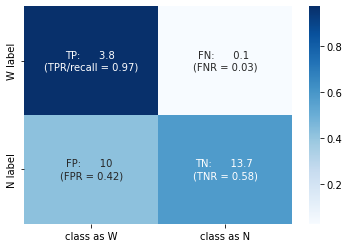

In [ ]:
train_keys = [
    "ukr_uk",
    "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 15, 'tn': 7, 'fp': 2, 'fn': 3, 'corrw': 0.83, 'spec': 0.78, 'prec': 0.88, 'fpr': 0.21999999999999997}, {'w': 18, 'n': 9, 'tp': 16, 'tn': 8, 'fp': 1, 'fn': 2, 'corrw': 0.89, 'spec': 0.89, 'prec': 0.94, 'fpr': 0.10999999999999999}, {'w': 19, 'n': 8, 'tp': 14, 'tn': 5, 'fp': 3, 'fn': 5, 'corrw': 0.74, 'spec': 0.62, 'prec': 0.82, 'fpr': 0.38}, {'w': 18, 'n': 8, 'tp': 14, 'tn': 6, 'fp': 2, 'fn': 4, 'corrw': 0.78, 'spec': 0.75, 'prec': 0.88, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 11, 'tn': 9, 'fp': 3, 'fn': 3, 'corrw': 0.79, 'spec': 0.75, 'prec': 0.79, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 10, 'tn': 10, 'fp': 2, 'fn': 4, 'corrw': 0.71, 'spec': 0.83, 'prec': 0.83, 'fpr': 0.17000000000000004}, {'w': 16, 'n': 10, 'tp': 11, 'tn': 8, 'fp': 2, 'fn': 5, 'corrw': 0.69, 'spec': 0.8, 'prec': 0.85, 'fpr': 0.19999999999999996}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 9, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.69, 'prec': 0.76, 'fpr': 0.31000000000000005}, {'w': 10, 'n': 1

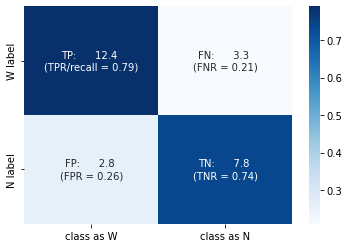


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 12, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.92, 'prec': 0.93, 'fpr': 0.07999999999999996}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 17, 'fp': 2, 'fn': 1, 'corrw': 0.88, 'spec': 0.89, 'prec': 0.78, 'fpr': 0.10999999999999999}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 12, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.67, 'prec': 0.6, 'fpr': 0.32999999999999996}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 10, 'fp': 5, 'fn': 2, 'corrw': 0.82, 'spec': 0.67, 'prec': 0.64, 'fpr': 0.32999999999999996}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 16, 'fp': 4, 'fn': 1, 'corrw': 0.83, 'spec': 0.8, 'prec': 0.56, 'fpr': 0.19999999999999996}, {'w': 11, 'n': 15, 'tp': 8, 'tn': 12, 'fp': 3, 'fn': 3, 'corrw': 0.73, 'spec': 0.8, 'prec': 0.73, 'fpr': 0.19999999999999996}, {'w': 8, 'n': 18, 'tp': 6, 'tn': 13, 'fp': 5, 'fn': 2, 'corrw': 0.75, 'spec': 0.72, 'prec': 0.55, 'fpr': 0.28}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 14, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.88, 'prec': 0.83, 'fpr': 0.12}, {'w'

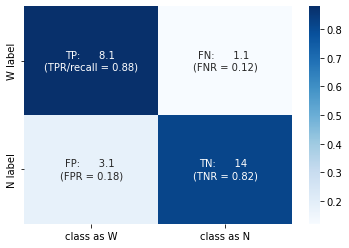


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 22, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.88, 'prec': 0.5, 'fpr': 0.12}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 21, 'fp': 3, 'fn': 1, 'corrw': 0.75, 'spec': 0.88, 'prec': 0.5, 'fpr': 0.12}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 22, 'fp': 3, 'fn': 1, 'corrw': 0.67, 'spec': 0.88, 'prec': 0.4, 'fpr': 0.12}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 19, 'fp': 3, 'fn': 1, 'corrw': 0.83, 'spec': 0.86, 'prec': 0.62, 'fpr': 0.14}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 24, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 19, 'fp': 3, 'fn': 1, 'corrw': 0.83, 'spec': 0.86, 'prec': 0.62, 'fpr': 0.14}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 16, 'fp': 6, 'fn': 1, 'corrw': 0.8, 'spec': 0.73, 'prec': 0.4, 'fpr': 0.27}, {'w': 2, 'n': 25, 'tp': 1, 'tn': 20, 'fp': 5, 'fn': 1, 'corrw': 0.5, 'spec': 0.8, 'prec': 0.17, 'fpr': 0.19999999999999996}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 21, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec

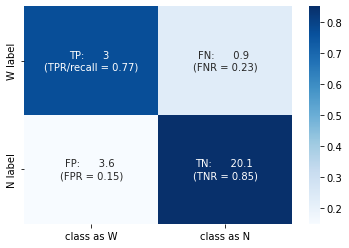

In [ ]:
train_keys = [
    # "ukr_uk",
    "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 15, 'tn': 8, 'fp': 1, 'fn': 3, 'corrw': 0.83, 'spec': 0.89, 'prec': 0.94, 'fpr': 0.10999999999999999}, {'w': 18, 'n': 9, 'tp': 16, 'tn': 7, 'fp': 2, 'fn': 2, 'corrw': 0.89, 'spec': 0.78, 'prec': 0.89, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 15, 'tn': 6, 'fp': 2, 'fn': 4, 'corrw': 0.79, 'spec': 0.75, 'prec': 0.88, 'fpr': 0.25}, {'w': 18, 'n': 8, 'tp': 15, 'tn': 6, 'fp': 2, 'fn': 3, 'corrw': 0.83, 'spec': 0.75, 'prec': 0.88, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 10, 'fp': 2, 'fn': 2, 'corrw': 0.86, 'spec': 0.83, 'prec': 0.86, 'fpr': 0.17000000000000004}, {'w': 14, 'n': 12, 'tp': 14, 'tn': 7, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.58, 'prec': 0.74, 'fpr': 0.42000000000000004}, {'w': 16, 'n': 10, 'tp': 13, 'tn': 7, 'fp': 3, 'fn': 3, 'corrw': 0.81, 'spec': 0.7, 'prec': 0.81, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 11, 'tn': 6, 'fp': 7, 'fn': 2, 'corrw': 0.85, 'spec': 0.46, 'prec': 0.61, 'fpr': 0.54}, {'w': 10, 'n': 1

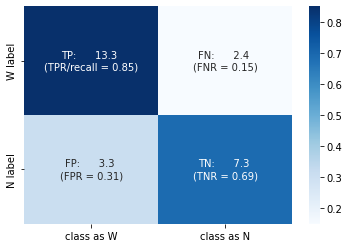


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 9, 'fp': 4, 'fn': 1, 'corrw': 0.93, 'spec': 0.69, 'prec': 0.76, 'fpr': 0.31000000000000005}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 17, 'fp': 2, 'fn': 1, 'corrw': 0.88, 'spec': 0.89, 'prec': 0.78, 'fpr': 0.10999999999999999}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 14, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.69, 'fpr': 0.21999999999999997}, {'w': 11, 'n': 15, 'tp': 11, 'tn': 8, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.53, 'prec': 0.61, 'fpr': 0.47}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 15, 'fp': 5, 'fn': 1, 'corrw': 0.83, 'spec': 0.75, 'prec': 0.5, 'fpr': 0.25}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 11, 'fp': 4, 'fn': 2, 'corrw': 0.82, 'spec': 0.73, 'prec': 0.69, 'fpr': 0.27}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 13, 'fp': 5, 'fn': 1, 'corrw': 0.88, 'spec': 0.72, 'prec': 0.58, 'fpr': 0.28}, {'w': 10, 'n': 16, 'tp': 9, 'tn': 13, 'fp': 3, 'fn': 1, 'corrw': 0.9, 'spec': 0.81, 'prec': 0.75, 'fpr': 0.18999999999999995}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 1

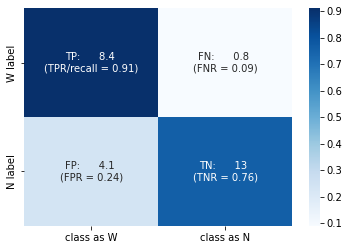


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 17, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.68, 'prec': 0.27, 'fpr': 0.31999999999999995}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 19, 'fp': 5, 'fn': 2, 'corrw': 0.5, 'spec': 0.79, 'prec': 0.29, 'fpr': 0.20999999999999996}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 19, 'fp': 6, 'fn': 1, 'corrw': 0.67, 'spec': 0.76, 'prec': 0.25, 'fpr': 0.24}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 18, 'fp': 4, 'fn': 1, 'corrw': 0.83, 'spec': 0.82, 'prec': 0.56, 'fpr': 0.18000000000000005}, {'w': 2, 'n': 26, 'tp': 1, 'tn': 22, 'fp': 4, 'fn': 1, 'corrw': 0.5, 'spec': 0.85, 'prec': 0.2, 'fpr': 0.15000000000000002}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 18, 'fp': 4, 'fn': 1, 'corrw': 0.83, 'spec': 0.82, 'prec': 0.56, 'fpr': 0.18000000000000005}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 15, 'fp': 7, 'fn': 1, 'corrw': 0.8, 'spec': 0.68, 'prec': 0.36, 'fpr': 0.31999999999999995}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 20, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.29, 'fpr': 0.1999999999999999

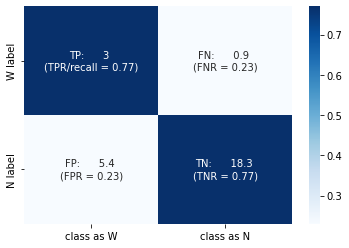

In [ ]:
train_keys = [
    "ukr_uk",
    # "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 6, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.67, 'prec': 0.84, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 17, 'tn': 8, 'fp': 1, 'fn': 1, 'corrw': 0.94, 'spec': 0.89, 'prec': 0.94, 'fpr': 0.10999999999999999}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 6, 'fp': 2, 'fn': 3, 'corrw': 0.84, 'spec': 0.75, 'prec': 0.89, 'fpr': 0.25}, {'w': 18, 'n': 8, 'tp': 15, 'tn': 5, 'fp': 3, 'fn': 3, 'corrw': 0.83, 'spec': 0.62, 'prec': 0.83, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 12, 'fp': 0, 'fn': 2, 'corrw': 0.86, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 14, 'n': 12, 'tp': 14, 'tn': 9, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.75, 'prec': 0.82, 'fpr': 0.25}, {'w': 16, 'n': 10, 'tp': 14, 'tn': 9, 'fp': 1, 'fn': 2, 'corrw': 0.88, 'spec': 0.9, 'prec': 0.93, 'fpr': 0.09999999999999998}, {'w': 13, 'n': 13, 'tp': 11, 'tn': 7, 'fp': 6, 'fn': 2, 'corrw': 0.85, 'spec': 0.54, 'prec': 0.65, 'fpr': 0.45999999999999996}, {'w': 10, 'n': 16, 'tp': 10, 'tn':

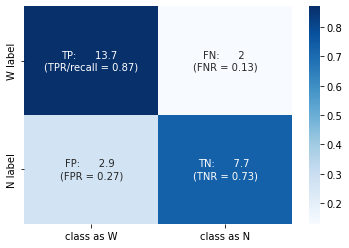


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 11, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.85, 'prec': 0.88, 'fpr': 0.15000000000000002}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 17, 'fp': 2, 'fn': 1, 'corrw': 0.88, 'spec': 0.89, 'prec': 0.78, 'fpr': 0.10999999999999999}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 13, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.72, 'prec': 0.64, 'fpr': 0.28}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 9, 'fp': 6, 'fn': 1, 'corrw': 0.91, 'spec': 0.6, 'prec': 0.62, 'fpr': 0.4}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 16, 'fp': 4, 'fn': 1, 'corrw': 0.83, 'spec': 0.8, 'prec': 0.56, 'fpr': 0.19999999999999996}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 10, 'fp': 5, 'fn': 2, 'corrw': 0.82, 'spec': 0.67, 'prec': 0.64, 'fpr': 0.32999999999999996}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 13, 'fp': 5, 'fn': 1, 'corrw': 0.88, 'spec': 0.72, 'prec': 0.58, 'fpr': 0.28}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 14, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.88, 'prec': 0.83, 'fpr': 0.12}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 1

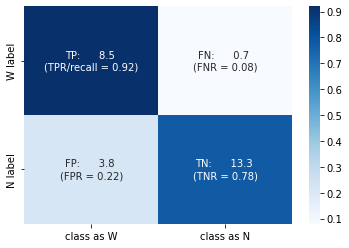


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 18, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.72, 'prec': 0.3, 'fpr': 0.28}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 19, 'fp': 5, 'fn': 1, 'corrw': 0.75, 'spec': 0.79, 'prec': 0.38, 'fpr': 0.20999999999999996}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 21, 'fp': 4, 'fn': 1, 'corrw': 0.67, 'spec': 0.84, 'prec': 0.33, 'fpr': 0.16000000000000003}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 17, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.55, 'fpr': 0.22999999999999998}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 24, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 19, 'fp': 3, 'fn': 1, 'corrw': 0.83, 'spec': 0.86, 'prec': 0.62, 'fpr': 0.14}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 14, 'fp': 8, 'fn': 1, 'corrw': 0.8, 'spec': 0.64, 'prec': 0.33, 'fpr': 0.36}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 20, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.29, 'fpr': 0.19999999999999996}, {'w': 4, 'n': 23, 'tp': 4, 

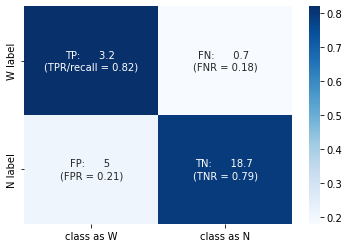

In [ ]:
train_keys = [
    "ukr_uk",
    "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

***
#'paraphrase-multilingual-mpnet-base-v2'

In [ ]:
model_name = 'paraphrase-multilingual-mpnet-base-v2'

paraphrase-multilingual-mpnet-base-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 6, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.67, 'prec': 0.84, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 18, 'tn': 5, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.82, 'fpr': 0.43999999999999995}, {'w': 19, 'n': 8, 'tp': 18, 'tn': 3, 'fp': 5, 'fn': 1, 'corrw': 0.95, 'spec': 0.38, 'prec': 0.78, 'fpr': 0.62}, {'w': 18, 'n': 8, 'tp': 15, 'tn': 3, 'fp': 5, 'fn': 3, 'corrw': 0.83, 'spec': 0.38, 'prec': 0.75, 'fpr': 0.62}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 7, 'fp': 5, 'fn': 2, 'corrw': 0.86, 'spec': 0.58, 'prec': 0.71, 'fpr': 0.42000000000000004}, {'w': 14, 'n': 12, 'tp': 14, 'tn': 7, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.58, 'prec': 0.74, 'fpr': 0.42000000000000004}, {'w': 16, 'n': 10, 'tp': 15, 'tn': 5, 'fp': 5, 'fn': 1, 'corrw': 0.94, 'spec': 0.5, 'prec': 0.75, 'fpr': 0.5}, {'w': 13, 'n': 13, 'tp': 12, 'tn': 6, 'fp': 7, 'fn': 1, 'corrw': 0.92, 'spec': 0.46, 'prec': 0.63, 'fpr': 0.54}, {'w': 10, 'n': 16, 'tp': 10, 'tn':

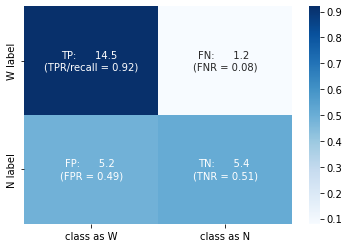


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 5, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.38, 'prec': 0.64, 'fpr': 0.62}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 13, 'fp': 6, 'fn': 1, 'corrw': 0.88, 'spec': 0.68, 'prec': 0.54, 'fpr': 0.31999999999999995}, {'w': 9, 'n': 18, 'tp': 7, 'tn': 12, 'fp': 6, 'fn': 2, 'corrw': 0.78, 'spec': 0.67, 'prec': 0.54, 'fpr': 0.32999999999999996}, {'w': 11, 'n': 15, 'tp': 11, 'tn': 8, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.53, 'prec': 0.61, 'fpr': 0.47}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 10, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.5, 'prec': 0.38, 'fpr': 0.5}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 8, 'fp': 7, 'fn': 1, 'corrw': 0.91, 'spec': 0.53, 'prec': 0.59, 'fpr': 0.47}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 9, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.5, 'prec': 0.47, 'fpr': 0.5}, {'w': 10, 'n': 16, 'tp': 9, 'tn': 8, 'fp': 8, 'fn': 1, 'corrw': 0.9, 'spec': 0.5, 'prec': 0.53, 'fpr': 0.5}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 10, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'sp

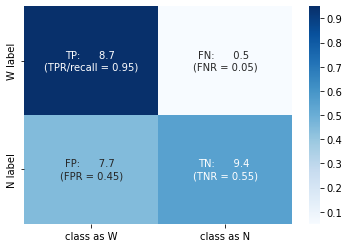


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 11, 'fp': 14, 'fn': 0, 'corrw': 1.0, 'spec': 0.44, 'prec': 0.18, 'fpr': 0.56}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 10, 'fp': 14, 'fn': 1, 'corrw': 0.75, 'spec': 0.42, 'prec': 0.18, 'fpr': 0.5800000000000001}, {'w': 3, 'n': 25, 'tp': 3, 'tn': 12, 'fp': 13, 'fn': 0, 'corrw': 1.0, 'spec': 0.48, 'prec': 0.19, 'fpr': 0.52}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 5, 'fp': 17, 'fn': 0, 'corrw': 1.0, 'spec': 0.23, 'prec': 0.26, 'fpr': 0.77}, {'w': 2, 'n': 26, 'tp': 1, 'tn': 13, 'fp': 13, 'fn': 1, 'corrw': 0.5, 'spec': 0.5, 'prec': 0.07, 'fpr': 0.5}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 12, 'fp': 10, 'fn': 1, 'corrw': 0.83, 'spec': 0.55, 'prec': 0.33, 'fpr': 0.44999999999999996}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 10, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.45, 'prec': 0.29, 'fpr': 0.55}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 10, 'fp': 15, 'fn': 0, 'corrw': 1.0, 'spec': 0.4, 'prec': 0.12, 'fpr': 0.6}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 9, 'fp': 14, 'fn': 0, 'corrw': 1.0,

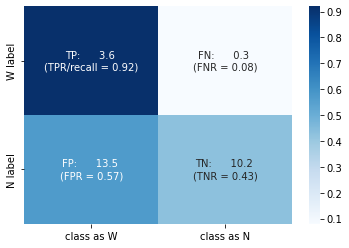

In [ ]:
train_keys = [
    "ukr_uk",
    # "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

paraphrase-multilingual-mpnet-base-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 6, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.67, 'prec': 0.84, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 18, 'tn': 5, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.82, 'fpr': 0.43999999999999995}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 6, 'fp': 2, 'fn': 3, 'corrw': 0.84, 'spec': 0.75, 'prec': 0.89, 'fpr': 0.25}, {'w': 18, 'n': 8, 'tp': 15, 'tn': 5, 'fp': 3, 'fn': 3, 'corrw': 0.83, 'spec': 0.62, 'prec': 0.83, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 7, 'fp': 5, 'fn': 2, 'corrw': 0.86, 'spec': 0.58, 'prec': 0.71, 'fpr': 0.42000000000000004}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 8, 'fp': 4, 'fn': 2, 'corrw': 0.86, 'spec': 0.67, 'prec': 0.75, 'fpr': 0.32999999999999996}, {'w': 16, 'n': 10, 'tp': 13, 'tn': 7, 'fp': 3, 'fn': 3, 'corrw': 0.81, 'spec': 0.7, 'prec': 0.81, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 5, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.38, 'prec': 0.62, 'fpr': 0.62}, {'w': 10, 'n': 16,

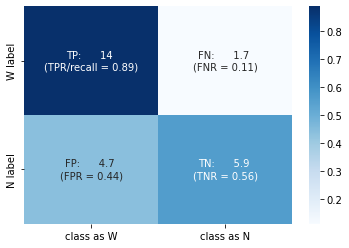


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 10, 'fp': 3, 'fn': 1, 'corrw': 0.93, 'spec': 0.77, 'prec': 0.81, 'fpr': 0.22999999999999998}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 15, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.79, 'prec': 0.67, 'fpr': 0.20999999999999996}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 10, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.53, 'fpr': 0.43999999999999995}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 12, 'fp': 3, 'fn': 1, 'corrw': 0.91, 'spec': 0.8, 'prec': 0.77, 'fpr': 0.19999999999999996}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 13, 'fp': 7, 'fn': 1, 'corrw': 0.83, 'spec': 0.65, 'prec': 0.42, 'fpr': 0.35}, {'w': 11, 'n': 15, 'tp': 11, 'tn': 7, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.47, 'prec': 0.58, 'fpr': 0.53}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 15, 'fp': 3, 'fn': 1, 'corrw': 0.88, 'spec': 0.83, 'prec': 0.7, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 9, 'tn': 12, 'fp': 4, 'fn': 1, 'corrw': 0.9, 'spec': 0.75, 'prec': 0.69, 'fpr': 0.25}, {'w': 8, 'n': 18, '

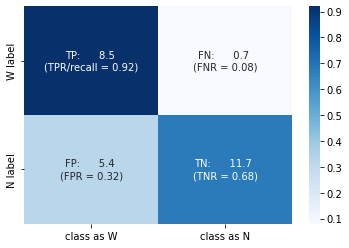


rus_ru: [{'w': 3, 'n': 25, 'tp': 2, 'tn': 18, 'fp': 7, 'fn': 1, 'corrw': 0.67, 'spec': 0.72, 'prec': 0.22, 'fpr': 0.28}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 15, 'fp': 9, 'fn': 2, 'corrw': 0.5, 'spec': 0.62, 'prec': 0.18, 'fpr': 0.38}, {'w': 3, 'n': 25, 'tp': 3, 'tn': 16, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.64, 'prec': 0.25, 'fpr': 0.36}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 13, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.59, 'prec': 0.4, 'fpr': 0.41000000000000003}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 16, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.62, 'prec': 0.17, 'fpr': 0.38}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 15, 'fp': 7, 'fn': 1, 'corrw': 0.83, 'spec': 0.68, 'prec': 0.42, 'fpr': 0.31999999999999995}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 12, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.55, 'prec': 0.33, 'fpr': 0.44999999999999996}, {'w': 2, 'n': 25, 'tp': 1, 'tn': 16, 'fp': 9, 'fn': 1, 'corrw': 0.5, 'spec': 0.64, 'prec': 0.1, 'fpr': 0.36}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 20, 'fp': 3, 'fn': 0, 

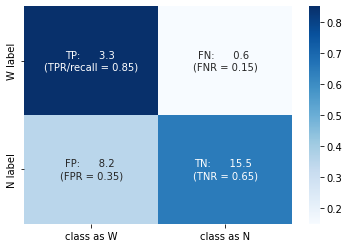

In [ ]:
train_keys = [
    # "ukr_uk",
    "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

paraphrase-multilingual-mpnet-base-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 8, 'tn': 9, 'fp': 0, 'fn': 10, 'corrw': 0.44, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 18, 'n': 9, 'tp': 10, 'tn': 8, 'fp': 1, 'fn': 8, 'corrw': 0.56, 'spec': 0.89, 'prec': 0.91, 'fpr': 0.10999999999999999}, {'w': 19, 'n': 8, 'tp': 3, 'tn': 8, 'fp': 0, 'fn': 16, 'corrw': 0.16, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 18, 'n': 8, 'tp': 11, 'tn': 8, 'fp': 0, 'fn': 7, 'corrw': 0.61, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 14, 'n': 12, 'tp': 5, 'tn': 11, 'fp': 1, 'fn': 9, 'corrw': 0.36, 'spec': 0.92, 'prec': 0.83, 'fpr': 0.07999999999999996}, {'w': 14, 'n': 12, 'tp': 6, 'tn': 12, 'fp': 0, 'fn': 8, 'corrw': 0.43, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 16, 'n': 10, 'tp': 8, 'tn': 10, 'fp': 0, 'fn': 8, 'corrw': 0.5, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 13, 'n': 13, 'tp': 7, 'tn': 10, 'fp': 3, 'fn': 6, 'corrw': 0.54, 'spec': 0.77, 'prec': 0.7, 'fpr': 0.22999999999999998}, {'w': 10, 'n': 16, 'tp': 5, 'tn': 14, 'fp': 2, 'fn': 5, 'corrw

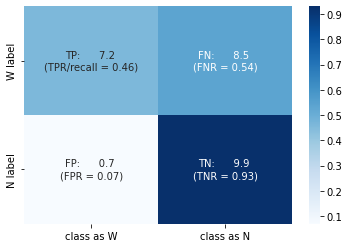


ukr_ru: [{'w': 14, 'n': 13, 'tp': 12, 'tn': 13, 'fp': 0, 'fn': 2, 'corrw': 0.86, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 17, 'fp': 2, 'fn': 1, 'corrw': 0.88, 'spec': 0.89, 'prec': 0.78, 'fpr': 0.10999999999999999}, {'w': 9, 'n': 18, 'tp': 8, 'tn': 16, 'fp': 2, 'fn': 1, 'corrw': 0.89, 'spec': 0.89, 'prec': 0.8, 'fpr': 0.10999999999999999}, {'w': 11, 'n': 15, 'tp': 5, 'tn': 14, 'fp': 1, 'fn': 6, 'corrw': 0.45, 'spec': 0.93, 'prec': 0.83, 'fpr': 0.06999999999999995}, {'w': 6, 'n': 20, 'tp': 4, 'tn': 17, 'fp': 3, 'fn': 2, 'corrw': 0.67, 'spec': 0.85, 'prec': 0.57, 'fpr': 0.15000000000000002}, {'w': 11, 'n': 15, 'tp': 7, 'tn': 13, 'fp': 2, 'fn': 4, 'corrw': 0.64, 'spec': 0.87, 'prec': 0.78, 'fpr': 0.13}, {'w': 8, 'n': 18, 'tp': 5, 'tn': 17, 'fp': 1, 'fn': 3, 'corrw': 0.62, 'spec': 0.94, 'prec': 0.83, 'fpr': 0.06000000000000005}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 15, 'fp': 1, 'fn': 2, 'corrw': 0.8, 'spec': 0.94, 'prec': 0.89, 'fpr': 0.06000000000000005}, {'w'

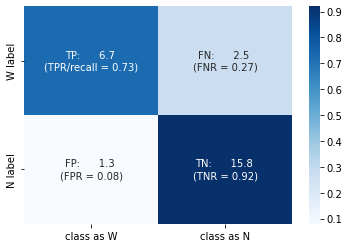


rus_ru: [{'w': 3, 'n': 25, 'tp': 2, 'tn': 25, 'fp': 0, 'fn': 1, 'corrw': 0.67, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 24, 'fp': 0, 'fn': 2, 'corrw': 0.5, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 25, 'fp': 0, 'fn': 2, 'corrw': 0.33, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 20, 'fp': 2, 'fn': 2, 'corrw': 0.67, 'spec': 0.91, 'prec': 0.67, 'fpr': 0.08999999999999997}, {'w': 2, 'n': 26, 'tp': 1, 'tn': 26, 'fp': 0, 'fn': 1, 'corrw': 0.5, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 6, 'n': 22, 'tp': 3, 'tn': 20, 'fp': 2, 'fn': 3, 'corrw': 0.5, 'spec': 0.91, 'prec': 0.6, 'fpr': 0.08999999999999997}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 20, 'fp': 2, 'fn': 1, 'corrw': 0.8, 'spec': 0.91, 'prec': 0.67, 'fpr': 0.08999999999999997}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 22, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.88, 'prec': 0.4, 'fpr': 0.12}, {'w': 4, 'n': 23, 'tp': 2, 'tn': 22, 'fp': 1, 'fn': 2, 'corrw': 0.5,

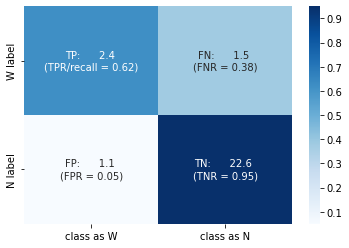

In [ ]:
train_keys = [
    # "ukr_uk",
    # "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

paraphrase-multilingual-mpnet-base-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 17, 'tn': 6, 'fp': 3, 'fn': 1, 'corrw': 0.94, 'spec': 0.67, 'prec': 0.85, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 18, 'tn': 7, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.9, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 17, 'tn': 5, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.62, 'prec': 0.85, 'fpr': 0.38}, {'w': 18, 'n': 8, 'tp': 15, 'tn': 5, 'fp': 3, 'fn': 3, 'corrw': 0.83, 'spec': 0.62, 'prec': 0.83, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 13, 'tn': 8, 'fp': 4, 'fn': 1, 'corrw': 0.93, 'spec': 0.67, 'prec': 0.76, 'fpr': 0.32999999999999996}, {'w': 14, 'n': 12, 'tp': 14, 'tn': 8, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.67, 'prec': 0.78, 'fpr': 0.32999999999999996}, {'w': 16, 'n': 10, 'tp': 16, 'tn': 6, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.6, 'prec': 0.8, 'fpr': 0.4}, {'w': 13, 'n': 13, 'tp': 12, 'tn': 8, 'fp': 5, 'fn': 1, 'corrw': 0.92, 'spec': 0.62, 'prec': 0.71, 'fpr': 0.38}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 8,

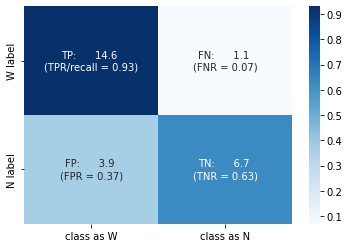


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 8, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.62, 'prec': 0.74, 'fpr': 0.38}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 17, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.89, 'prec': 0.8, 'fpr': 0.10999999999999999}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 14, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.69, 'fpr': 0.21999999999999997}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 9, 'fp': 6, 'fn': 2, 'corrw': 0.82, 'spec': 0.6, 'prec': 0.6, 'fpr': 0.4}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 13, 'fp': 7, 'fn': 1, 'corrw': 0.83, 'spec': 0.65, 'prec': 0.42, 'fpr': 0.35}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 10, 'fp': 5, 'fn': 1, 'corrw': 0.91, 'spec': 0.67, 'prec': 0.67, 'fpr': 0.32999999999999996}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 14, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.67, 'fpr': 0.21999999999999997}, {'w': 10, 'n': 16, 'tp': 9, 'tn': 10, 'fp': 6, 'fn': 1, 'corrw': 0.9, 'spec': 0.62, 'prec': 0.6, 'fpr': 0.38}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 11, 'fp

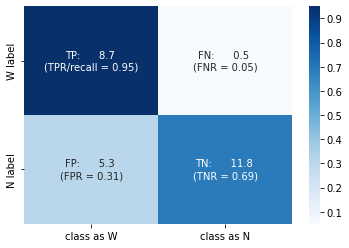


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 15, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.6, 'prec': 0.23, 'fpr': 0.4}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 15, 'fp': 9, 'fn': 1, 'corrw': 0.75, 'spec': 0.62, 'prec': 0.25, 'fpr': 0.38}, {'w': 3, 'n': 25, 'tp': 3, 'tn': 13, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.52, 'prec': 0.2, 'fpr': 0.48}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 10, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.45, 'prec': 0.33, 'fpr': 0.55}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 18, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.69, 'prec': 0.2, 'fpr': 0.31000000000000005}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 15, 'fp': 7, 'fn': 1, 'corrw': 0.83, 'spec': 0.68, 'prec': 0.42, 'fpr': 0.31999999999999995}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 12, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.55, 'prec': 0.33, 'fpr': 0.44999999999999996}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 14, 'fp': 11, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.15, 'fpr': 0.43999999999999995}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 17, 'f

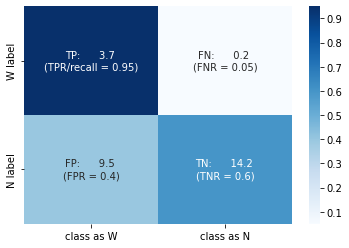

In [ ]:
train_keys = [
    "ukr_uk",
    "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

paraphrase-multilingual-mpnet-base-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 15, 'tn': 9, 'fp': 0, 'fn': 3, 'corrw': 0.83, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 18, 'n': 9, 'tp': 14, 'tn': 7, 'fp': 2, 'fn': 4, 'corrw': 0.78, 'spec': 0.78, 'prec': 0.88, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 15, 'tn': 7, 'fp': 1, 'fn': 4, 'corrw': 0.79, 'spec': 0.88, 'prec': 0.94, 'fpr': 0.12}, {'w': 18, 'n': 8, 'tp': 13, 'tn': 5, 'fp': 3, 'fn': 5, 'corrw': 0.72, 'spec': 0.62, 'prec': 0.81, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 10, 'tn': 9, 'fp': 3, 'fn': 4, 'corrw': 0.71, 'spec': 0.75, 'prec': 0.77, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 10, 'tn': 9, 'fp': 3, 'fn': 4, 'corrw': 0.71, 'spec': 0.75, 'prec': 0.77, 'fpr': 0.25}, {'w': 16, 'n': 10, 'tp': 12, 'tn': 8, 'fp': 2, 'fn': 4, 'corrw': 0.75, 'spec': 0.8, 'prec': 0.86, 'fpr': 0.19999999999999996}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 9, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.69, 'prec': 0.76, 'fpr': 0.31000000000000005}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 9, 'fp': 7, 'fn

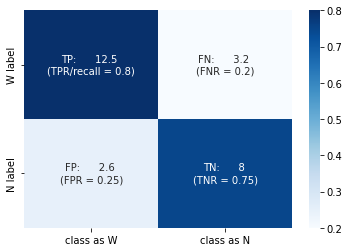


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 11, 'fp': 2, 'fn': 1, 'corrw': 0.93, 'spec': 0.85, 'prec': 0.87, 'fpr': 0.15000000000000002}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 18, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.95, 'prec': 0.89, 'fpr': 0.050000000000000044}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 12, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.67, 'prec': 0.6, 'fpr': 0.32999999999999996}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 12, 'fp': 3, 'fn': 2, 'corrw': 0.82, 'spec': 0.8, 'prec': 0.75, 'fpr': 0.19999999999999996}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 16, 'fp': 4, 'fn': 1, 'corrw': 0.83, 'spec': 0.8, 'prec': 0.56, 'fpr': 0.19999999999999996}, {'w': 11, 'n': 15, 'tp': 8, 'tn': 11, 'fp': 4, 'fn': 3, 'corrw': 0.73, 'spec': 0.73, 'prec': 0.67, 'fpr': 0.27}, {'w': 8, 'n': 18, 'tp': 6, 'tn': 16, 'fp': 2, 'fn': 2, 'corrw': 0.75, 'spec': 0.89, 'prec': 0.75, 'fpr': 0.10999999999999999}, {'w': 10, 'n': 16, 'tp': 9, 'tn': 15, 'fp': 1, 'fn': 1, 'corrw': 0.9, 'spec': 0.94, 'prec': 0.9, 'fpr': 0.0600000000

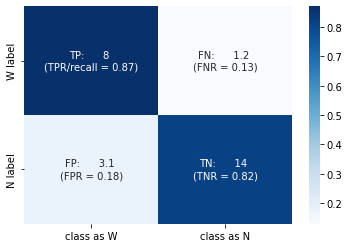


rus_ru: [{'w': 3, 'n': 25, 'tp': 2, 'tn': 23, 'fp': 2, 'fn': 1, 'corrw': 0.67, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 22, 'fp': 2, 'fn': 2, 'corrw': 0.5, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 23, 'fp': 2, 'fn': 2, 'corrw': 0.33, 'spec': 0.92, 'prec': 0.33, 'fpr': 0.07999999999999996}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 19, 'fp': 3, 'fn': 2, 'corrw': 0.67, 'spec': 0.86, 'prec': 0.57, 'fpr': 0.14}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 25, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.96, 'prec': 0.67, 'fpr': 0.040000000000000036}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 18, 'fp': 4, 'fn': 2, 'corrw': 0.67, 'spec': 0.82, 'prec': 0.5, 'fpr': 0.18000000000000005}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 17, 'fp': 5, 'fn': 1, 'corrw': 0.8, 'spec': 0.77, 'prec': 0.44, 'fpr': 0.22999999999999998}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 21, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.84, 'prec': 0.33, 'fpr': 0.160000000000000

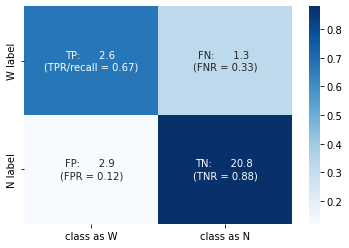

In [ ]:
train_keys = [
    # "ukr_uk",
    "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

paraphrase-multilingual-mpnet-base-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 7, 'fp': 2, 'fn': 2, 'corrw': 0.89, 'spec': 0.78, 'prec': 0.89, 'fpr': 0.21999999999999997}, {'w': 18, 'n': 9, 'tp': 17, 'tn': 7, 'fp': 2, 'fn': 1, 'corrw': 0.94, 'spec': 0.78, 'prec': 0.89, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 7, 'fp': 1, 'fn': 3, 'corrw': 0.84, 'spec': 0.88, 'prec': 0.94, 'fpr': 0.12}, {'w': 18, 'n': 8, 'tp': 14, 'tn': 5, 'fp': 3, 'fn': 4, 'corrw': 0.78, 'spec': 0.62, 'prec': 0.82, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 10, 'fp': 2, 'fn': 2, 'corrw': 0.86, 'spec': 0.83, 'prec': 0.86, 'fpr': 0.17000000000000004}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 9, 'fp': 3, 'fn': 2, 'corrw': 0.86, 'spec': 0.75, 'prec': 0.8, 'fpr': 0.25}, {'w': 16, 'n': 10, 'tp': 14, 'tn': 7, 'fp': 3, 'fn': 2, 'corrw': 0.88, 'spec': 0.7, 'prec': 0.82, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 11, 'tn': 8, 'fp': 5, 'fn': 2, 'corrw': 0.85, 'spec': 0.62, 'prec': 0.69, 'fpr': 0.38}, {'w': 10, 'n': 16, 'tp': 10, 't

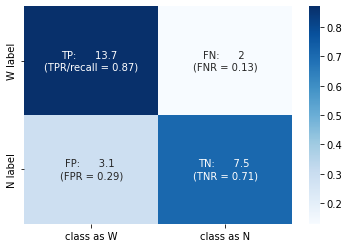


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 9, 'fp': 4, 'fn': 1, 'corrw': 0.93, 'spec': 0.69, 'prec': 0.76, 'fpr': 0.31000000000000005}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 18, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.95, 'prec': 0.89, 'fpr': 0.050000000000000044}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 14, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.69, 'fpr': 0.21999999999999997}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 8, 'fp': 7, 'fn': 2, 'corrw': 0.82, 'spec': 0.53, 'prec': 0.56, 'fpr': 0.47}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 16, 'fp': 4, 'fn': 1, 'corrw': 0.83, 'spec': 0.8, 'prec': 0.56, 'fpr': 0.19999999999999996}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 12, 'fp': 3, 'fn': 2, 'corrw': 0.82, 'spec': 0.8, 'prec': 0.75, 'fpr': 0.19999999999999996}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 15, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.83, 'prec': 0.73, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 13, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.81, 'prec': 0.77, 'fpr': 0.1899999999

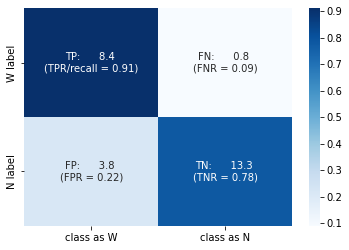


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 20, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.38, 'fpr': 0.19999999999999996}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 20, 'fp': 4, 'fn': 2, 'corrw': 0.5, 'spec': 0.83, 'prec': 0.33, 'fpr': 0.17000000000000004}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 22, 'fp': 3, 'fn': 1, 'corrw': 0.67, 'spec': 0.88, 'prec': 0.4, 'fpr': 0.12}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 14, 'fp': 8, 'fn': 2, 'corrw': 0.67, 'spec': 0.64, 'prec': 0.33, 'fpr': 0.36}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 21, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.81, 'prec': 0.29, 'fpr': 0.18999999999999995}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 18, 'fp': 4, 'fn': 2, 'corrw': 0.67, 'spec': 0.82, 'prec': 0.5, 'fpr': 0.18000000000000005}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 18, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.82, 'prec': 0.56, 'fpr': 0.18000000000000005}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 18, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.72, 'prec': 0.22, 'fpr': 0.28}, {'w': 4, 'n': 23, 'tp': 4, 

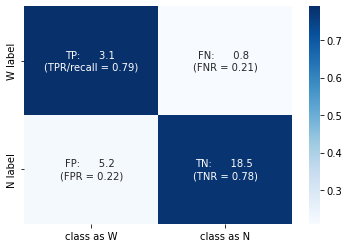

In [ ]:
train_keys = [
    "ukr_uk",
    # "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

paraphrase-multilingual-mpnet-base-v2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 16, 'tn': 6, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.67, 'prec': 0.84, 'fpr': 0.32999999999999996}, {'w': 18, 'n': 9, 'tp': 17, 'tn': 8, 'fp': 1, 'fn': 1, 'corrw': 0.94, 'spec': 0.89, 'prec': 0.94, 'fpr': 0.10999999999999999}, {'w': 19, 'n': 8, 'tp': 16, 'tn': 7, 'fp': 1, 'fn': 3, 'corrw': 0.84, 'spec': 0.88, 'prec': 0.94, 'fpr': 0.12}, {'w': 18, 'n': 8, 'tp': 14, 'tn': 6, 'fp': 2, 'fn': 4, 'corrw': 0.78, 'spec': 0.75, 'prec': 0.88, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 13, 'tn': 10, 'fp': 2, 'fn': 1, 'corrw': 0.93, 'spec': 0.83, 'prec': 0.87, 'fpr': 0.17000000000000004}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 9, 'fp': 3, 'fn': 2, 'corrw': 0.86, 'spec': 0.75, 'prec': 0.8, 'fpr': 0.25}, {'w': 16, 'n': 10, 'tp': 14, 'tn': 7, 'fp': 3, 'fn': 2, 'corrw': 0.88, 'spec': 0.7, 'prec': 0.82, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 12, 'tn': 9, 'fp': 4, 'fn': 1, 'corrw': 0.92, 'spec': 0.69, 'prec': 0.75, 'fpr': 0.31000000000000005}, {'w': 10, 'n': 1

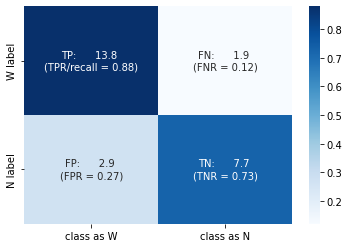


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 10, 'fp': 3, 'fn': 1, 'corrw': 0.93, 'spec': 0.77, 'prec': 0.81, 'fpr': 0.22999999999999998}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 18, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.95, 'prec': 0.89, 'fpr': 0.050000000000000044}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 14, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.78, 'prec': 0.69, 'fpr': 0.21999999999999997}, {'w': 11, 'n': 15, 'tp': 7, 'tn': 10, 'fp': 5, 'fn': 4, 'corrw': 0.64, 'spec': 0.67, 'prec': 0.58, 'fpr': 0.32999999999999996}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 15, 'fp': 5, 'fn': 1, 'corrw': 0.83, 'spec': 0.75, 'prec': 0.5, 'fpr': 0.25}, {'w': 11, 'n': 15, 'tp': 8, 'tn': 11, 'fp': 4, 'fn': 3, 'corrw': 0.73, 'spec': 0.73, 'prec': 0.67, 'fpr': 0.27}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 15, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.83, 'prec': 0.73, 'fpr': 0.17000000000000004}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 13, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.81, 'prec': 0.77, 'fpr': 0.18999999999999995}, {'

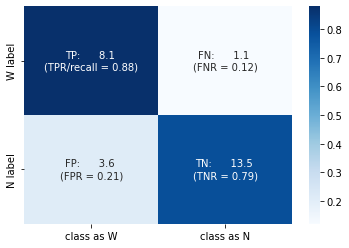


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 20, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.38, 'fpr': 0.19999999999999996}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 20, 'fp': 4, 'fn': 2, 'corrw': 0.5, 'spec': 0.83, 'prec': 0.33, 'fpr': 0.17000000000000004}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 23, 'fp': 2, 'fn': 1, 'corrw': 0.67, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 13, 'fp': 9, 'fn': 1, 'corrw': 0.83, 'spec': 0.59, 'prec': 0.36, 'fpr': 0.41000000000000003}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 22, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.85, 'prec': 0.33, 'fpr': 0.15000000000000002}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 19, 'fp': 3, 'fn': 2, 'corrw': 0.67, 'spec': 0.86, 'prec': 0.57, 'fpr': 0.14}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 15, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.68, 'prec': 0.42, 'fpr': 0.31999999999999995}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 17, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.68, 'prec': 0.2, 'fpr': 0.31999999999999995

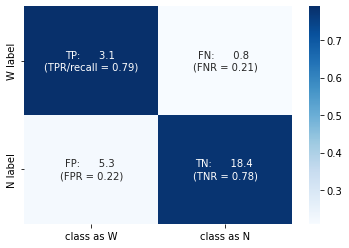

In [ ]:
train_keys = [
    "ukr_uk",
    "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

***
# 'distiluse-base-multilingual-cased-v1' (no UK)

In [ ]:
model_name = 'distiluse-base-multilingual-cased-v1' # no UK

distiluse-base-multilingual-cased-v1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 17, 'tn': 3, 'fp': 6, 'fn': 1, 'corrw': 0.94, 'spec': 0.33, 'prec': 0.74, 'fpr': 0.6699999999999999}, {'w': 18, 'n': 9, 'tp': 14, 'tn': 3, 'fp': 6, 'fn': 4, 'corrw': 0.78, 'spec': 0.33, 'prec': 0.7, 'fpr': 0.6699999999999999}, {'w': 19, 'n': 8, 'tp': 15, 'tn': 3, 'fp': 5, 'fn': 4, 'corrw': 0.79, 'spec': 0.38, 'prec': 0.75, 'fpr': 0.62}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 5, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.62, 'prec': 0.84, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 10, 'tn': 6, 'fp': 6, 'fn': 4, 'corrw': 0.71, 'spec': 0.5, 'prec': 0.62, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 3, 'fp': 9, 'fn': 2, 'corrw': 0.86, 'spec': 0.25, 'prec': 0.57, 'fpr': 0.75}, {'w': 16, 'n': 10, 'tp': 15, 'tn': 2, 'fp': 8, 'fn': 1, 'corrw': 0.94, 'spec': 0.2, 'prec': 0.65, 'fpr': 0.8}, {'w': 13, 'n': 13, 'tp': 11, 'tn': 4, 'fp': 9, 'fn': 2, 'corrw': 0.85, 'spec': 0.31, 'prec': 0.55, 'fpr': 0.69}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 8, 'fp': 8, 'fn': 2, 'corrw': 0.8

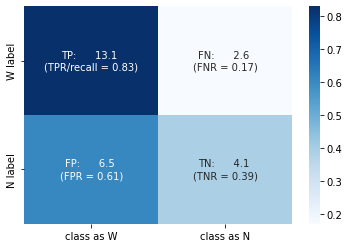


ukr_ru: [{'w': 14, 'n': 13, 'tp': 12, 'tn': 7, 'fp': 6, 'fn': 2, 'corrw': 0.86, 'spec': 0.54, 'prec': 0.67, 'fpr': 0.45999999999999996}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 12, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.63, 'prec': 0.53, 'fpr': 0.37}, {'w': 9, 'n': 18, 'tp': 8, 'tn': 11, 'fp': 7, 'fn': 1, 'corrw': 0.89, 'spec': 0.61, 'prec': 0.53, 'fpr': 0.39}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 9, 'fp': 6, 'fn': 2, 'corrw': 0.82, 'spec': 0.6, 'prec': 0.6, 'fpr': 0.4}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 8, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.4, 'prec': 0.33, 'fpr': 0.6}, {'w': 11, 'n': 15, 'tp': 8, 'tn': 3, 'fp': 12, 'fn': 3, 'corrw': 0.73, 'spec': 0.2, 'prec': 0.4, 'fpr': 0.8}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 10, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.5, 'fpr': 0.43999999999999995}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 6, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.38, 'prec': 0.5, 'fpr': 0.62}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 8, 'fp': 10, 'fn': 1, 'corrw': 0.88, 'spe

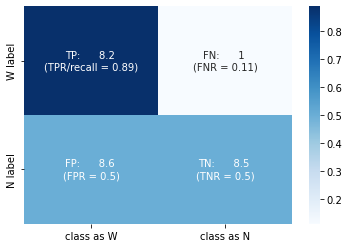


rus_ru: [{'w': 3, 'n': 25, 'tp': 1, 'tn': 10, 'fp': 15, 'fn': 2, 'corrw': 0.33, 'spec': 0.4, 'prec': 0.06, 'fpr': 0.6}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 9, 'fp': 15, 'fn': 1, 'corrw': 0.75, 'spec': 0.38, 'prec': 0.17, 'fpr': 0.62}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 12, 'fp': 13, 'fn': 1, 'corrw': 0.67, 'spec': 0.48, 'prec': 0.13, 'fpr': 0.52}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 7, 'fp': 15, 'fn': 2, 'corrw': 0.67, 'spec': 0.32, 'prec': 0.21, 'fpr': 0.6799999999999999}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 8, 'fp': 18, 'fn': 0, 'corrw': 1.0, 'spec': 0.31, 'prec': 0.1, 'fpr': 0.69}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 8, 'fp': 14, 'fn': 1, 'corrw': 0.83, 'spec': 0.36, 'prec': 0.26, 'fpr': 0.64}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 4, 'fp': 18, 'fn': 0, 'corrw': 1.0, 'spec': 0.18, 'prec': 0.22, 'fpr': 0.8200000000000001}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 8, 'fp': 17, 'fn': 0, 'corrw': 1.0, 'spec': 0.32, 'prec': 0.11, 'fpr': 0.6799999999999999}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 8, 'fp': 15, 'fn': 0, '

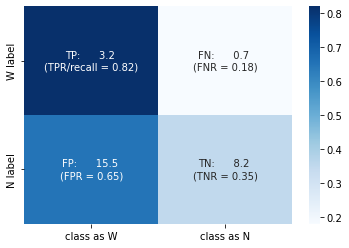

In [ ]:
train_keys = [
    "ukr_uk",
    # "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 15, 'tn': 2, 'fp': 7, 'fn': 3, 'corrw': 0.83, 'spec': 0.22, 'prec': 0.68, 'fpr': 0.78}, {'w': 18, 'n': 9, 'tp': 17, 'tn': 4, 'fp': 5, 'fn': 1, 'corrw': 0.94, 'spec': 0.44, 'prec': 0.77, 'fpr': 0.56}, {'w': 19, 'n': 8, 'tp': 15, 'tn': 0, 'fp': 8, 'fn': 4, 'corrw': 0.79, 'spec': 0.0, 'prec': 0.65, 'fpr': 1.0}, {'w': 18, 'n': 8, 'tp': 18, 'tn': 2, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.25, 'prec': 0.75, 'fpr': 0.75}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 6, 'fp': 6, 'fn': 2, 'corrw': 0.86, 'spec': 0.5, 'prec': 0.67, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 5, 'fp': 7, 'fn': 2, 'corrw': 0.86, 'spec': 0.42, 'prec': 0.63, 'fpr': 0.5800000000000001}, {'w': 16, 'n': 10, 'tp': 14, 'tn': 7, 'fp': 3, 'fn': 2, 'corrw': 0.88, 'spec': 0.7, 'prec': 0.82, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 13, 'tn': 3, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.23, 'prec': 0.57, 'fpr': 0.77}, {'w': 10, 'n': 16, 'tp': 9, 'tn': 4, 'fp': 12, 'fn': 1, 'corrw': 0.

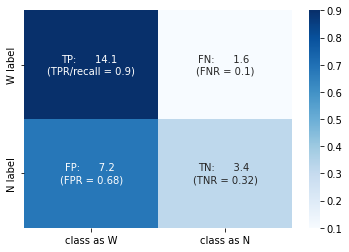


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 10, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.82, 'fpr': 0.22999999999999998}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 15, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.79, 'prec': 0.67, 'fpr': 0.20999999999999996}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 9, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.5, 'prec': 0.5, 'fpr': 0.5}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 11, 'fp': 4, 'fn': 1, 'corrw': 0.91, 'spec': 0.73, 'prec': 0.71, 'fpr': 0.27}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 17, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.85, 'prec': 0.67, 'fpr': 0.15000000000000002}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 8, 'fp': 7, 'fn': 1, 'corrw': 0.91, 'spec': 0.53, 'prec': 0.59, 'fpr': 0.47}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 14, 'fp': 4, 'fn': 1, 'corrw': 0.88, 'spec': 0.78, 'prec': 0.64, 'fpr': 0.21999999999999997}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 11, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.69, 'prec': 0.67, 'fpr': 0.31000000000000005}, {'w': 8, 'n': 18, 'tp

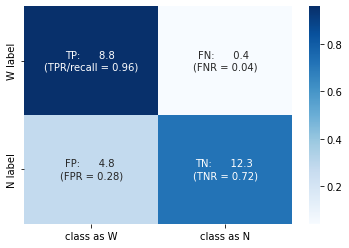


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 18, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.72, 'prec': 0.3, 'fpr': 0.28}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 16, 'fp': 8, 'fn': 1, 'corrw': 0.75, 'spec': 0.67, 'prec': 0.27, 'fpr': 0.32999999999999996}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 13, 'fp': 12, 'fn': 1, 'corrw': 0.67, 'spec': 0.52, 'prec': 0.14, 'fpr': 0.48}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 12, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.55, 'prec': 0.38, 'fpr': 0.44999999999999996}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 20, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.25, 'fpr': 0.22999999999999998}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 17, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.55, 'fpr': 0.22999999999999998}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 12, 'fp': 10, 'fn': 0, 'corrw': 1.0, 'spec': 0.55, 'prec': 0.33, 'fpr': 0.44999999999999996}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 17, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.68, 'prec': 0.2, 'fpr': 0.31999999999999995}, {'w': 4, 

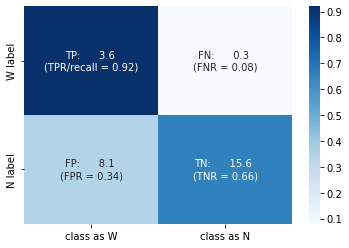

In [ ]:
train_keys = [
    # "ukr_uk",
    "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 7, 'tn': 7, 'fp': 2, 'fn': 11, 'corrw': 0.39, 'spec': 0.78, 'prec': 0.78, 'fpr': 0.21999999999999997}, {'w': 18, 'n': 9, 'tp': 10, 'tn': 7, 'fp': 2, 'fn': 8, 'corrw': 0.56, 'spec': 0.78, 'prec': 0.83, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 5, 'tn': 5, 'fp': 3, 'fn': 14, 'corrw': 0.26, 'spec': 0.62, 'prec': 0.62, 'fpr': 0.38}, {'w': 18, 'n': 8, 'tp': 10, 'tn': 6, 'fp': 2, 'fn': 8, 'corrw': 0.56, 'spec': 0.75, 'prec': 0.83, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 7, 'tn': 9, 'fp': 3, 'fn': 7, 'corrw': 0.5, 'spec': 0.75, 'prec': 0.7, 'fpr': 0.25}, {'w': 14, 'n': 12, 'tp': 3, 'tn': 11, 'fp': 1, 'fn': 11, 'corrw': 0.21, 'spec': 0.92, 'prec': 0.75, 'fpr': 0.07999999999999996}, {'w': 16, 'n': 10, 'tp': 6, 'tn': 7, 'fp': 3, 'fn': 10, 'corrw': 0.38, 'spec': 0.7, 'prec': 0.67, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 6, 'tn': 10, 'fp': 3, 'fn': 7, 'corrw': 0.46, 'spec': 0.77, 'prec': 0.67, 'fpr': 0.22999999999999998}, {'w': 10, 'n': 16,

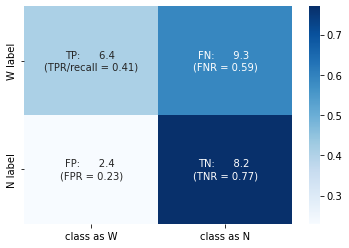


ukr_ru: [{'w': 14, 'n': 13, 'tp': 12, 'tn': 13, 'fp': 0, 'fn': 2, 'corrw': 0.86, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 8, 'n': 19, 'tp': 6, 'tn': 18, 'fp': 1, 'fn': 2, 'corrw': 0.75, 'spec': 0.95, 'prec': 0.86, 'fpr': 0.050000000000000044}, {'w': 9, 'n': 18, 'tp': 8, 'tn': 16, 'fp': 2, 'fn': 1, 'corrw': 0.89, 'spec': 0.89, 'prec': 0.8, 'fpr': 0.10999999999999999}, {'w': 11, 'n': 15, 'tp': 7, 'tn': 15, 'fp': 0, 'fn': 4, 'corrw': 0.64, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 18, 'fp': 2, 'fn': 1, 'corrw': 0.83, 'spec': 0.9, 'prec': 0.71, 'fpr': 0.09999999999999998}, {'w': 11, 'n': 15, 'tp': 6, 'tn': 14, 'fp': 1, 'fn': 5, 'corrw': 0.55, 'spec': 0.93, 'prec': 0.86, 'fpr': 0.06999999999999995}, {'w': 8, 'n': 18, 'tp': 5, 'tn': 17, 'fp': 1, 'fn': 3, 'corrw': 0.62, 'spec': 0.94, 'prec': 0.83, 'fpr': 0.06000000000000005}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 14, 'fp': 2, 'fn': 2, 'corrw': 0.8, 'spec': 0.88, 'prec': 0.8, 'fpr': 0.12}, {'w': 8, 'n': 18, 'tp':

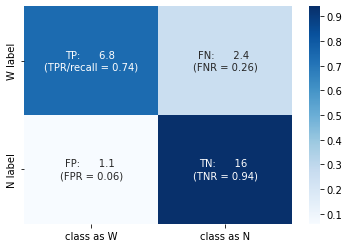


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 24, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.96, 'prec': 0.75, 'fpr': 0.040000000000000036}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 23, 'fp': 1, 'fn': 2, 'corrw': 0.5, 'spec': 0.96, 'prec': 0.67, 'fpr': 0.040000000000000036}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 23, 'fp': 2, 'fn': 2, 'corrw': 0.33, 'spec': 0.92, 'prec': 0.33, 'fpr': 0.07999999999999996}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 20, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.91, 'prec': 0.75, 'fpr': 0.08999999999999997}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 25, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.96, 'prec': 0.67, 'fpr': 0.040000000000000036}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 21, 'fp': 1, 'fn': 2, 'corrw': 0.67, 'spec': 0.95, 'prec': 0.8, 'fpr': 0.050000000000000044}, {'w': 5, 'n': 22, 'tp': 3, 'tn': 21, 'fp': 1, 'fn': 2, 'corrw': 0.6, 'spec': 0.95, 'prec': 0.75, 'fpr': 0.050000000000000044}, {'w': 2, 'n': 25, 'tp': 1, 'tn': 22, 'fp': 3, 'fn': 1, 'corrw': 0.5, 'spec': 0.88, 'prec': 0.25, 'fpr'

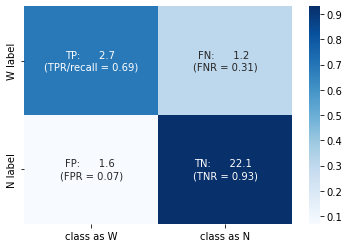

In [ ]:
train_keys = [
    # "ukr_uk",
    # "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 17, 'tn': 3, 'fp': 6, 'fn': 1, 'corrw': 0.94, 'spec': 0.33, 'prec': 0.74, 'fpr': 0.6699999999999999}, {'w': 18, 'n': 9, 'tp': 14, 'tn': 4, 'fp': 5, 'fn': 4, 'corrw': 0.78, 'spec': 0.44, 'prec': 0.74, 'fpr': 0.56}, {'w': 19, 'n': 8, 'tp': 15, 'tn': 2, 'fp': 6, 'fn': 4, 'corrw': 0.79, 'spec': 0.25, 'prec': 0.71, 'fpr': 0.75}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 5, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.62, 'prec': 0.84, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 11, 'tn': 6, 'fp': 6, 'fn': 3, 'corrw': 0.79, 'spec': 0.5, 'prec': 0.65, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 5, 'fp': 7, 'fn': 2, 'corrw': 0.86, 'spec': 0.42, 'prec': 0.63, 'fpr': 0.5800000000000001}, {'w': 16, 'n': 10, 'tp': 15, 'tn': 2, 'fp': 8, 'fn': 1, 'corrw': 0.94, 'spec': 0.2, 'prec': 0.65, 'fpr': 0.8}, {'w': 13, 'n': 13, 'tp': 11, 'tn': 5, 'fp': 8, 'fn': 2, 'corrw': 0.85, 'spec': 0.38, 'prec': 0.58, 'fpr': 0.62}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 8, 'fp': 8, 'fn': 2, 'corrw': 0.

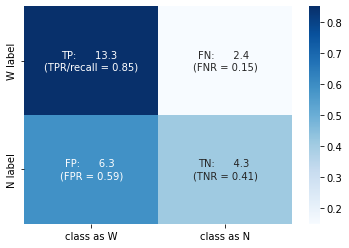


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 10, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.77, 'prec': 0.82, 'fpr': 0.22999999999999998}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 14, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.74, 'prec': 0.62, 'fpr': 0.26}, {'w': 9, 'n': 18, 'tp': 9, 'tn': 11, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.61, 'prec': 0.56, 'fpr': 0.39}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 10, 'fp': 5, 'fn': 2, 'corrw': 0.82, 'spec': 0.67, 'prec': 0.64, 'fpr': 0.32999999999999996}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 17, 'fp': 3, 'fn': 1, 'corrw': 0.83, 'spec': 0.85, 'prec': 0.62, 'fpr': 0.15000000000000002}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 7, 'fp': 8, 'fn': 2, 'corrw': 0.82, 'spec': 0.47, 'prec': 0.53, 'fpr': 0.53}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 14, 'fp': 4, 'fn': 1, 'corrw': 0.88, 'spec': 0.78, 'prec': 0.64, 'fpr': 0.21999999999999997}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 10, 'fp': 6, 'fn': 0, 'corrw': 1.0, 'spec': 0.62, 'prec': 0.62, 'fpr': 0.38}, {'w': 8, 'n': 18, 'tp': 8, 'tn': 

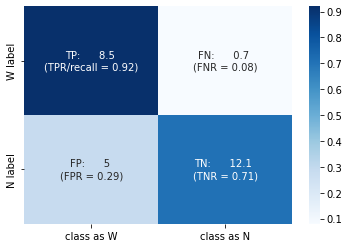


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 16, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.64, 'prec': 0.25, 'fpr': 0.36}, {'w': 4, 'n': 24, 'tp': 3, 'tn': 15, 'fp': 9, 'fn': 1, 'corrw': 0.75, 'spec': 0.62, 'prec': 0.25, 'fpr': 0.38}, {'w': 3, 'n': 25, 'tp': 2, 'tn': 15, 'fp': 10, 'fn': 1, 'corrw': 0.67, 'spec': 0.6, 'prec': 0.17, 'fpr': 0.4}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 10, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.45, 'prec': 0.33, 'fpr': 0.55}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 17, 'fp': 9, 'fn': 0, 'corrw': 1.0, 'spec': 0.65, 'prec': 0.18, 'fpr': 0.35}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 13, 'fp': 9, 'fn': 1, 'corrw': 0.83, 'spec': 0.59, 'prec': 0.36, 'fpr': 0.41000000000000003}, {'w': 5, 'n': 22, 'tp': 5, 'tn': 10, 'fp': 12, 'fn': 0, 'corrw': 1.0, 'spec': 0.45, 'prec': 0.29, 'fpr': 0.55}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 17, 'fp': 8, 'fn': 0, 'corrw': 1.0, 'spec': 0.68, 'prec': 0.2, 'fpr': 0.31999999999999995}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 13, 'fp': 10, 'fn': 0, 'corrw': 1.0,

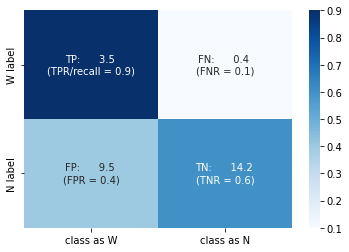

In [ ]:
train_keys = [
    "ukr_uk",
    "ukr_ru",
    # "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 13, 'tn': 3, 'fp': 6, 'fn': 5, 'corrw': 0.72, 'spec': 0.33, 'prec': 0.68, 'fpr': 0.6699999999999999}, {'w': 18, 'n': 9, 'tp': 15, 'tn': 7, 'fp': 2, 'fn': 3, 'corrw': 0.83, 'spec': 0.78, 'prec': 0.88, 'fpr': 0.21999999999999997}, {'w': 19, 'n': 8, 'tp': 12, 'tn': 1, 'fp': 7, 'fn': 7, 'corrw': 0.63, 'spec': 0.12, 'prec': 0.63, 'fpr': 0.88}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 3, 'fp': 5, 'fn': 2, 'corrw': 0.89, 'spec': 0.38, 'prec': 0.76, 'fpr': 0.62}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 7, 'fp': 5, 'fn': 2, 'corrw': 0.86, 'spec': 0.58, 'prec': 0.71, 'fpr': 0.42000000000000004}, {'w': 14, 'n': 12, 'tp': 11, 'tn': 7, 'fp': 5, 'fn': 3, 'corrw': 0.79, 'spec': 0.58, 'prec': 0.69, 'fpr': 0.42000000000000004}, {'w': 16, 'n': 10, 'tp': 14, 'tn': 7, 'fp': 3, 'fn': 2, 'corrw': 0.88, 'spec': 0.7, 'prec': 0.82, 'fpr': 0.30000000000000004}, {'w': 13, 'n': 13, 'tp': 12, 'tn': 5, 'fp': 8, 'fn': 1, 'corrw': 0.92, 'spec': 0.38, 'prec': 0.6, 'fpr': 0.62}, {'w': 10, 'n': 16,

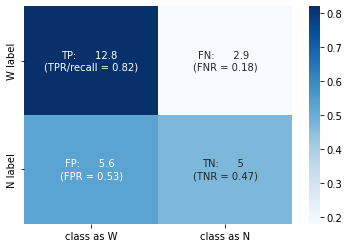


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 11, 'fp': 2, 'fn': 1, 'corrw': 0.93, 'spec': 0.85, 'prec': 0.87, 'fpr': 0.15000000000000002}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 17, 'fp': 2, 'fn': 1, 'corrw': 0.88, 'spec': 0.89, 'prec': 0.78, 'fpr': 0.10999999999999999}, {'w': 9, 'n': 18, 'tp': 8, 'tn': 14, 'fp': 4, 'fn': 1, 'corrw': 0.89, 'spec': 0.78, 'prec': 0.67, 'fpr': 0.21999999999999997}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 13, 'fp': 2, 'fn': 1, 'corrw': 0.91, 'spec': 0.87, 'prec': 0.83, 'fpr': 0.13}, {'w': 6, 'n': 20, 'tp': 5, 'tn': 18, 'fp': 2, 'fn': 1, 'corrw': 0.83, 'spec': 0.9, 'prec': 0.71, 'fpr': 0.09999999999999998}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 13, 'fp': 2, 'fn': 2, 'corrw': 0.82, 'spec': 0.87, 'prec': 0.82, 'fpr': 0.13}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 16, 'fp': 2, 'fn': 1, 'corrw': 0.88, 'spec': 0.89, 'prec': 0.78, 'fpr': 0.10999999999999999}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 12, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.75, 'prec': 0.71, 'fpr': 0.25}, {'w': 8, 'n': 

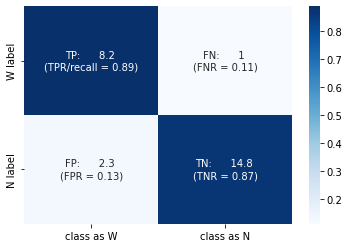


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 23, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.92, 'prec': 0.6, 'fpr': 0.07999999999999996}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 23, 'fp': 1, 'fn': 2, 'corrw': 0.5, 'spec': 0.96, 'prec': 0.67, 'fpr': 0.040000000000000036}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 22, 'fp': 3, 'fn': 2, 'corrw': 0.33, 'spec': 0.88, 'prec': 0.25, 'fpr': 0.12}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 20, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.91, 'prec': 0.75, 'fpr': 0.08999999999999997}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 26, 'fp': 0, 'fn': 0, 'corrw': 1.0, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 22, 'fp': 0, 'fn': 2, 'corrw': 0.67, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 19, 'fp': 3, 'fn': 1, 'corrw': 0.8, 'spec': 0.86, 'prec': 0.57, 'fpr': 0.14}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 23, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.92, 'prec': 0.5, 'fpr': 0.07999999999999996}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 17, 'fp': 6, '

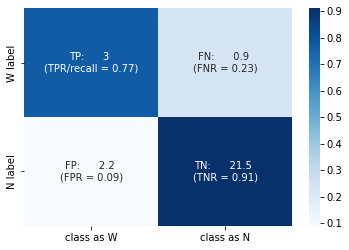

In [ ]:
train_keys = [
    # "ukr_uk",
    "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 17, 'tn': 4, 'fp': 5, 'fn': 1, 'corrw': 0.94, 'spec': 0.44, 'prec': 0.77, 'fpr': 0.56}, {'w': 18, 'n': 9, 'tp': 14, 'tn': 3, 'fp': 6, 'fn': 4, 'corrw': 0.78, 'spec': 0.33, 'prec': 0.7, 'fpr': 0.6699999999999999}, {'w': 19, 'n': 8, 'tp': 15, 'tn': 3, 'fp': 5, 'fn': 4, 'corrw': 0.79, 'spec': 0.38, 'prec': 0.75, 'fpr': 0.62}, {'w': 18, 'n': 8, 'tp': 15, 'tn': 5, 'fp': 3, 'fn': 3, 'corrw': 0.83, 'spec': 0.62, 'prec': 0.83, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 10, 'tn': 6, 'fp': 6, 'fn': 4, 'corrw': 0.71, 'spec': 0.5, 'prec': 0.62, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 3, 'fp': 9, 'fn': 2, 'corrw': 0.86, 'spec': 0.25, 'prec': 0.57, 'fpr': 0.75}, {'w': 16, 'n': 10, 'tp': 15, 'tn': 2, 'fp': 8, 'fn': 1, 'corrw': 0.94, 'spec': 0.2, 'prec': 0.65, 'fpr': 0.8}, {'w': 13, 'n': 13, 'tp': 11, 'tn': 5, 'fp': 8, 'fn': 2, 'corrw': 0.85, 'spec': 0.38, 'prec': 0.58, 'fpr': 0.62}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 8, 'fp': 8, 'fn': 2, 'corrw': 0.8, 'spec': 0.5,

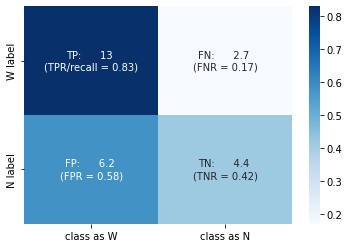


ukr_ru: [{'w': 14, 'n': 13, 'tp': 13, 'tn': 9, 'fp': 4, 'fn': 1, 'corrw': 0.93, 'spec': 0.69, 'prec': 0.76, 'fpr': 0.31000000000000005}, {'w': 8, 'n': 19, 'tp': 7, 'tn': 16, 'fp': 3, 'fn': 1, 'corrw': 0.88, 'spec': 0.84, 'prec': 0.7, 'fpr': 0.16000000000000003}, {'w': 9, 'n': 18, 'tp': 8, 'tn': 14, 'fp': 4, 'fn': 1, 'corrw': 0.89, 'spec': 0.78, 'prec': 0.67, 'fpr': 0.21999999999999997}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 12, 'fp': 3, 'fn': 1, 'corrw': 0.91, 'spec': 0.8, 'prec': 0.77, 'fpr': 0.19999999999999996}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 16, 'fp': 4, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.6, 'fpr': 0.19999999999999996}, {'w': 11, 'n': 15, 'tp': 6, 'tn': 10, 'fp': 5, 'fn': 5, 'corrw': 0.55, 'spec': 0.67, 'prec': 0.55, 'fpr': 0.32999999999999996}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 14, 'fp': 4, 'fn': 1, 'corrw': 0.88, 'spec': 0.78, 'prec': 0.64, 'fpr': 0.21999999999999997}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 9, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec': 0.56, 'prec': 0.59, 'fpr

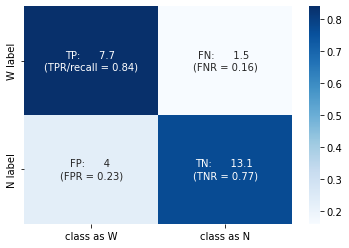


rus_ru: [{'w': 3, 'n': 25, 'tp': 2, 'tn': 20, 'fp': 5, 'fn': 1, 'corrw': 0.67, 'spec': 0.8, 'prec': 0.29, 'fpr': 0.19999999999999996}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 19, 'fp': 5, 'fn': 2, 'corrw': 0.5, 'spec': 0.79, 'prec': 0.29, 'fpr': 0.20999999999999996}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 19, 'fp': 6, 'fn': 2, 'corrw': 0.33, 'spec': 0.76, 'prec': 0.14, 'fpr': 0.24}, {'w': 6, 'n': 22, 'tp': 5, 'tn': 18, 'fp': 4, 'fn': 1, 'corrw': 0.83, 'spec': 0.82, 'prec': 0.56, 'fpr': 0.18000000000000005}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 25, 'fp': 1, 'fn': 0, 'corrw': 1.0, 'spec': 0.96, 'prec': 0.67, 'fpr': 0.040000000000000036}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 19, 'fp': 3, 'fn': 2, 'corrw': 0.67, 'spec': 0.86, 'prec': 0.57, 'fpr': 0.14}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 20, 'fp': 2, 'fn': 1, 'corrw': 0.8, 'spec': 0.91, 'prec': 0.67, 'fpr': 0.08999999999999997}, {'w': 2, 'n': 25, 'tp': 1, 'tn': 19, 'fp': 6, 'fn': 1, 'corrw': 0.5, 'spec': 0.76, 'prec': 0.14, 'fpr': 0.24}, {'w': 4, 'n': 23, 'tp':

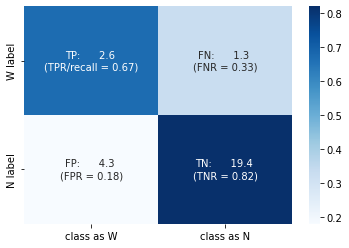

In [ ]:
train_keys = [
    "ukr_uk",
    # "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)

distiluse-base-multilingual-cased-v1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



ukr_uk: [{'w': 18, 'n': 9, 'tp': 17, 'tn': 4, 'fp': 5, 'fn': 1, 'corrw': 0.94, 'spec': 0.44, 'prec': 0.77, 'fpr': 0.56}, {'w': 18, 'n': 9, 'tp': 14, 'tn': 4, 'fp': 5, 'fn': 4, 'corrw': 0.78, 'spec': 0.44, 'prec': 0.74, 'fpr': 0.56}, {'w': 19, 'n': 8, 'tp': 15, 'tn': 2, 'fp': 6, 'fn': 4, 'corrw': 0.79, 'spec': 0.25, 'prec': 0.71, 'fpr': 0.75}, {'w': 18, 'n': 8, 'tp': 16, 'tn': 5, 'fp': 3, 'fn': 2, 'corrw': 0.89, 'spec': 0.62, 'prec': 0.84, 'fpr': 0.38}, {'w': 14, 'n': 12, 'tp': 11, 'tn': 6, 'fp': 6, 'fn': 3, 'corrw': 0.79, 'spec': 0.5, 'prec': 0.65, 'fpr': 0.5}, {'w': 14, 'n': 12, 'tp': 12, 'tn': 5, 'fp': 7, 'fn': 2, 'corrw': 0.86, 'spec': 0.42, 'prec': 0.63, 'fpr': 0.5800000000000001}, {'w': 16, 'n': 10, 'tp': 15, 'tn': 3, 'fp': 7, 'fn': 1, 'corrw': 0.94, 'spec': 0.3, 'prec': 0.68, 'fpr': 0.7}, {'w': 13, 'n': 13, 'tp': 11, 'tn': 5, 'fp': 8, 'fn': 2, 'corrw': 0.85, 'spec': 0.38, 'prec': 0.58, 'fpr': 0.62}, {'w': 10, 'n': 16, 'tp': 8, 'tn': 8, 'fp': 8, 'fn': 2, 'corrw': 0.8, 'spec': 0.5

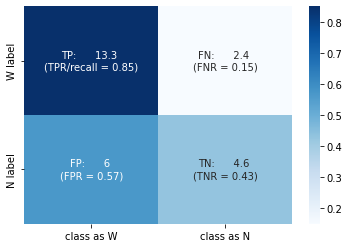


ukr_ru: [{'w': 14, 'n': 13, 'tp': 14, 'tn': 11, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.85, 'prec': 0.88, 'fpr': 0.15000000000000002}, {'w': 8, 'n': 19, 'tp': 8, 'tn': 16, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.84, 'prec': 0.73, 'fpr': 0.16000000000000003}, {'w': 9, 'n': 18, 'tp': 8, 'tn': 15, 'fp': 3, 'fn': 1, 'corrw': 0.89, 'spec': 0.83, 'prec': 0.73, 'fpr': 0.17000000000000004}, {'w': 11, 'n': 15, 'tp': 10, 'tn': 12, 'fp': 3, 'fn': 1, 'corrw': 0.91, 'spec': 0.8, 'prec': 0.77, 'fpr': 0.19999999999999996}, {'w': 6, 'n': 20, 'tp': 6, 'tn': 18, 'fp': 2, 'fn': 0, 'corrw': 1.0, 'spec': 0.9, 'prec': 0.75, 'fpr': 0.09999999999999998}, {'w': 11, 'n': 15, 'tp': 9, 'tn': 10, 'fp': 5, 'fn': 2, 'corrw': 0.82, 'spec': 0.67, 'prec': 0.64, 'fpr': 0.32999999999999996}, {'w': 8, 'n': 18, 'tp': 7, 'tn': 13, 'fp': 5, 'fn': 1, 'corrw': 0.88, 'spec': 0.72, 'prec': 0.58, 'fpr': 0.28}, {'w': 10, 'n': 16, 'tp': 10, 'tn': 11, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.69, 'prec': 0.67, 'fpr': 0.31000000

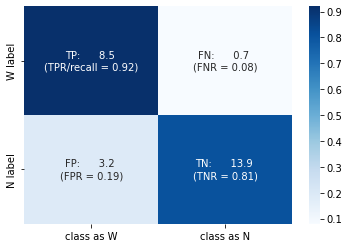


rus_ru: [{'w': 3, 'n': 25, 'tp': 3, 'tn': 22, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.88, 'prec': 0.5, 'fpr': 0.12}, {'w': 4, 'n': 24, 'tp': 2, 'tn': 21, 'fp': 3, 'fn': 2, 'corrw': 0.5, 'spec': 0.88, 'prec': 0.4, 'fpr': 0.12}, {'w': 3, 'n': 25, 'tp': 1, 'tn': 17, 'fp': 8, 'fn': 2, 'corrw': 0.33, 'spec': 0.68, 'prec': 0.11, 'fpr': 0.31999999999999995}, {'w': 6, 'n': 22, 'tp': 6, 'tn': 19, 'fp': 3, 'fn': 0, 'corrw': 1.0, 'spec': 0.86, 'prec': 0.67, 'fpr': 0.14}, {'w': 2, 'n': 26, 'tp': 2, 'tn': 26, 'fp': 0, 'fn': 0, 'corrw': 1.0, 'spec': 1.0, 'prec': 1.0, 'fpr': 0.0}, {'w': 6, 'n': 22, 'tp': 4, 'tn': 19, 'fp': 3, 'fn': 2, 'corrw': 0.67, 'spec': 0.86, 'prec': 0.57, 'fpr': 0.14}, {'w': 5, 'n': 22, 'tp': 4, 'tn': 19, 'fp': 3, 'fn': 1, 'corrw': 0.8, 'spec': 0.86, 'prec': 0.57, 'fpr': 0.14}, {'w': 2, 'n': 25, 'tp': 2, 'tn': 20, 'fp': 5, 'fn': 0, 'corrw': 1.0, 'spec': 0.8, 'prec': 0.29, 'fpr': 0.19999999999999996}, {'w': 4, 'n': 23, 'tp': 4, 'tn': 16, 'fp': 7, 'fn': 0, 'corrw': 1.0, 'spec':

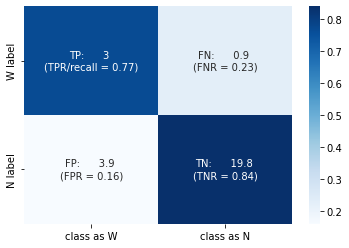

In [ ]:
train_keys = [
    "ukr_uk",
    "ukr_ru",
    "rus_ru",
]
run(model_name, train_keys, knn=3)